In [624]:
#from google.colab import drive
#drive.mount('/content/gdrive')

## Importing

In [625]:
# @title imports
#!/usr/bin/env python

try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen
import pandas
import certifi
import json
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
from dateutil import parser
import matplotlib.pyplot as plt
import csv
import os
import ast
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree, metrics
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import datasets
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
import warnings
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import time
from typing import List, Dict
from functools import reduce
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn import datasets, metrics, svm
from sklearn.svm import SVR
from sklearn.metrics import auc, roc_auc_score, mean_squared_error
from sklearn.datasets import fetch_openml
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.feature_selection import SelectFromModel
from IPython.display import Image
from scipy import interp
import matplotlib.patches as patches
import statsmodels.api as sm
warnings.filterwarnings('ignore')
import h5py
warnings.resetwarnings()


In [626]:
# @title helper functions
def trend_sliding_window(data, window_size, horizon):
    """
    Create input/output pairs for trend prediction using a sliding window approach.
    Args:
        data (array-like): The time series data.
        window_size (int): The size of the sliding window.
        horizon (int): The prediction horizon indicating how many steps ahead to predict.

    Returns:
        tuple: A tuple containing the input sequences (X) and the corresponding output values (y).
    """
    X, y = [], []
    for i in range(len(data) - window_size - horizon ):
        input_window = data[i:i+window_size]
        X.append(input_window)      # Input Sequence
        output_window = data[ i + window_size  : i + window_size  + horizon]
        trend_value   = data[ i + window_size - 1  + horizon] - data[ i + window_size + 1]
        y.append(output_window)     # Output Sequence
    return np.array(X), np.array(y)


def sliding_window_th(data,labels ,window_size, horizon, th):
  X, y = [], []
  for i in range(len(data) - window_size - horizon ):
    input_window = data[i:i+window_size]
    trend_value = labels[ i + window_size + horizon - 1] -  labels[i+window_size - 1]

    if ( trend_value > th):
      y_trend =  1
    elif ( trend_value < -1*th):
      y_trend = -1
    else:
      y_trend = 0
    X.append(input_window)      # Input Sequence
    y.append(y_trend)     # Output Sequence
  return np.array(X), np.array(y)


def Get_Dummies(feature, predict_feature, train_data, test_data):
  train_data = pd.get_dummies(train_data, prefix=[feature], columns = [feature], drop_first=True)
  ordered_cols = [x for x in train_data.columns if x not in[predict_feature]] + [predict_feature]
  train_data = train_data[ordered_cols]
  test_data = pd.get_dummies(test_data, prefix=[feature], columns = [feature], drop_first=True)
  return train_data, test_data


def add_feature(X: np.array ,y: np.array ,current_features, sigma_hat_squared: float):
    best_score = np.inf
    num_of_features = X.shape[1]
    for i in range(num_of_features):
        if i in current_features:
            continue
        current_features_copy_added_feature = current_features.copy()
        current_features_copy_added_feature.append(i)
        current_features_copy_added_feature.sort()
        current_Cp = get_mallows_cp_score(X[:, current_features_copy_added_feature], y, sigma_hat_squared)
        if (current_Cp <= best_score):
            best_score = current_Cp
            best_features_lst = current_features_copy_added_feature

    return {'features':sorted(best_features_lst),'score':best_score}

def get_mallows_cp_score(X: np.array ,y: np.array, sigma_hat_squared: float) -> float:
    reg  = LinearRegression()
    reg.fit(X, y)
    preds = reg.predict(X)
    MSE = mean_squared_error(y, preds)
    d = X.shape[1]
    n = len(X)
    Cp = MSE + (2* sigma_hat_squared * (d + 1)) / n
    return Cp

def get_sigma_hat_squared(X: np.array, y: np.array) -> float:
    reg  = LinearRegression()
    reg.fit(X, y)
    y_preds = reg.predict(X)
    MSE = mean_squared_error(y, y_preds)
    RSS = MSE * len(X)
    sigma_hat_squared = RSS / (len(X) - len(X[1]) - 1)
    return sigma_hat_squared

def forward_selection(X: np.array, y: np.array):
    num_of_features = X.shape[1]
    current_features = []
    # Calculate error on model with all features
    sigma_hat_squared = get_sigma_hat_squared(X, y)

    models_lst = []
    for i in range(num_of_features):
        res = add_feature(X,y,current_features,sigma_hat_squared)
        models_lst.append(res)
        current_features = models_lst[-1]['features']

    #Plotting
    scores_lst = [x['score'] for x in models_lst]
    plt.plot(range(1,len(scores_lst)+1),scores_lst, 'g')
    plt.xlabel("number of features")
    plt.ylabel("Mallows cp")
    plt.title("Mallows Cp score VS number of features")
    plt.show()

    #Returning features of best model, based on mcp score
    best_model = min(models_lst, key = lambda x: x['score'])
    best_features = best_model['features']
    return sorted(best_features)

# Initial Observation

First of all, we'd like to see how different features distribute, how they correlate with each other and also find out more statistic information about them

For now we'll focus on Apple stock

#### Raw Data

In [627]:
###### change to your spesific location on the drive

#df_path =  '/content/gdrive/My Drive/Datasets/data/Other/temp/AAPL.csv'    # change path , links raw.
#df = pd.read_csv(df_path)
df= pd.read_csv('C:/Users/niroe/OneDrive/Documents/Important/project/df_daily/Observed/AAPL.csv')
# df.head()

In [628]:
df.head()

date     open     high      low   close    adjClose     volume   
0  2023-06-09  181.500  182.230  180.630  180.99  180.960007   32456348  \
1  2023-06-08  177.895  180.840  177.460  180.57  180.570007   50210681   
2  2023-06-07  178.440  181.210  177.320  177.82  177.820007   61944615   
3  2023-06-06  179.965  180.120  177.430  179.21  179.210007   64845314   
4  2023-06-05  182.630  184.951  178.035  179.58  179.580002  121722517   

   unadjustedVolume  change  changePercent    vwap        label   
0          47304520  -0.510       -0.28099  181.58  June 09, 23  \
1          50214900   2.675        1.50000  179.55  June 08, 23   
2          61944600  -0.620       -0.34746  178.66  June 07, 23   
3          64848400  -0.755       -0.41953  178.71  June 06, 23   
4         121946500  -3.050       -1.67000  182.14  June 05, 23   

   changeOverTime  
0       -0.002810  
1        0.015000  
2       -0.003475  
3       -0.004195  
4       -0.016700

The features in the data are:
- Date: A string containing the observation's date.
- Open: The opening price of the stock on the date of the observation.
- High: The highest price the stock had on the trading day of the observation.
- Low: The lowest price the stock had on the trading day of the observation.
- Close: The closing price of the stock on the date of the observation.
- AdjClose: The closing price of the stock on the date of the observation after dividends.
- Volume: Number of stocks being traded on the day of the observation.
- UnAdjustedVolume: Same as Volume, but without any adjustments.
- Change: The difference between the open and close.
- ChangePercent: Same as change but in percentages.
- VWAP: VWAP stands for Volume-Weighted Average Price of the stock in the observation.
- Label: The date of the observation as a different string then the "Date" feature.
- ChangeOverTime: "ChangePercent" divided by 100.

### Visualization

##### Viewing the whole data at once

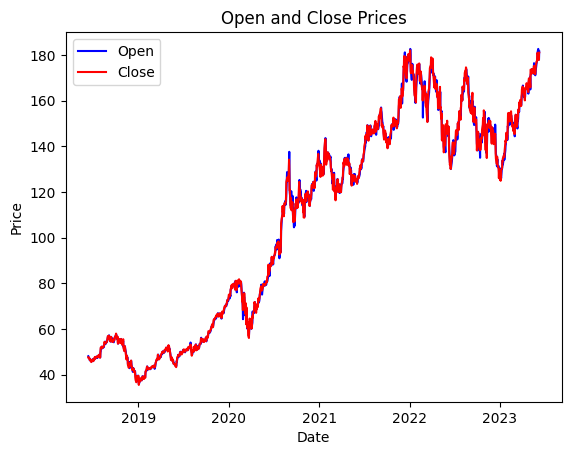

In [629]:
# Convert 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
df.reset_index(drop=True, inplace=True)

# Set up the figure and axis
fig, ax = plt.subplots()

# Plot 'open' and 'close' prices
ax.plot(df['date'], df['open'], color='blue', label='Open')
ax.plot(df['date'], df['close'], color='red', label='Close')

# Set the title and axis labels
ax.set_title('Open and Close Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

# Add a legend
ax.legend()

# Display the plot
plt.show()

##### Viewing each month separately for better viewing

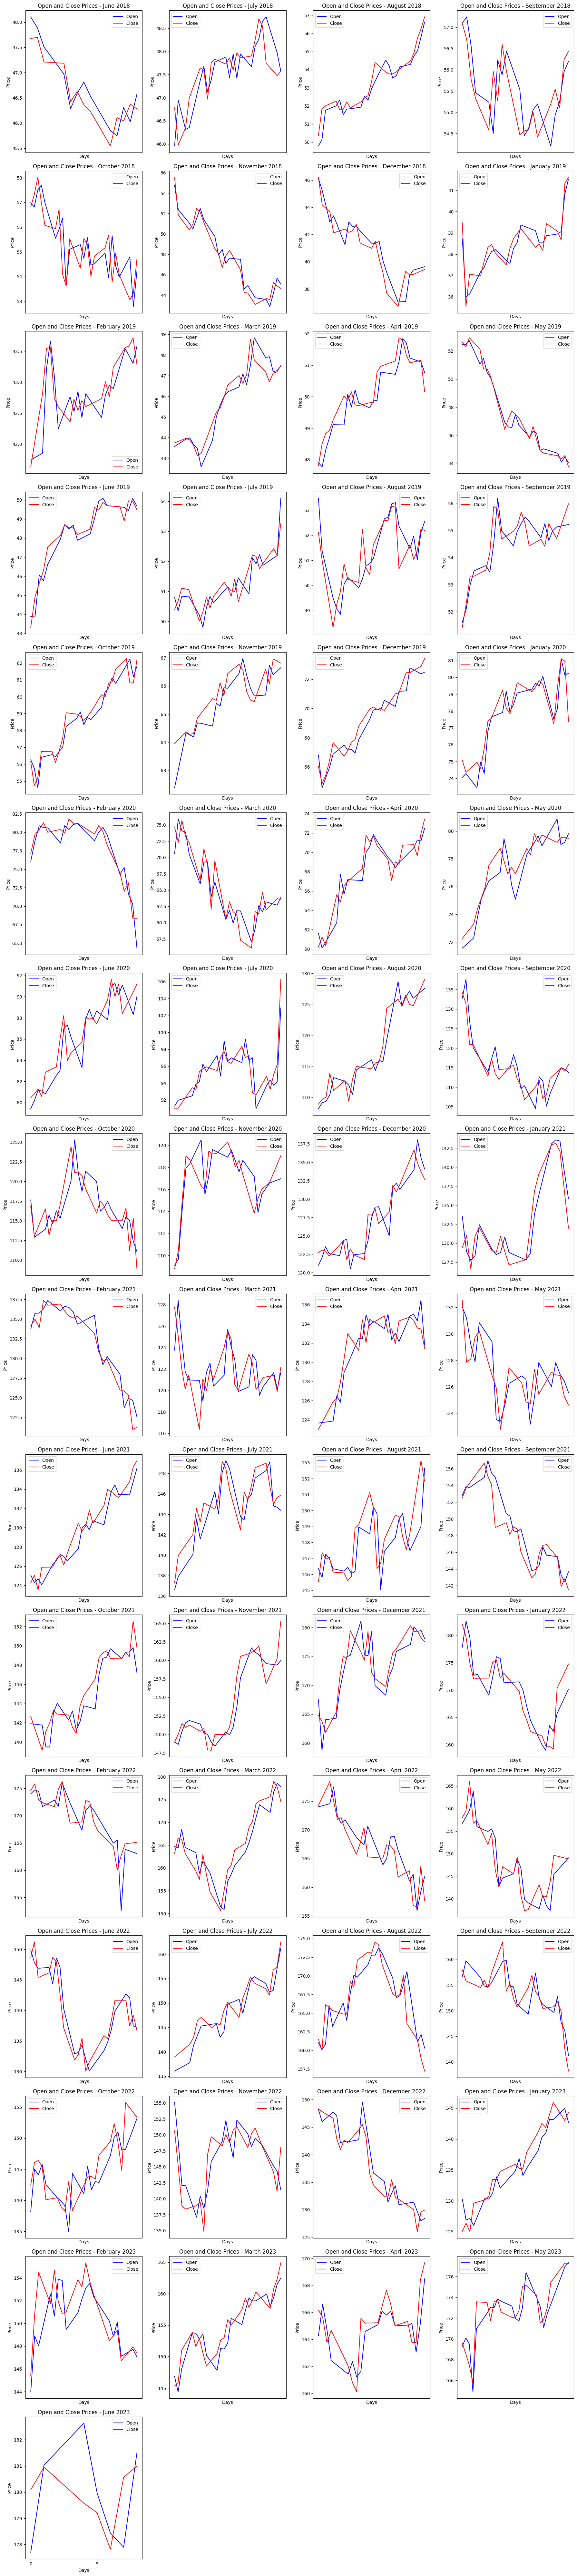

In [630]:
# Convert 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

# Group data by month
grouped_data = df.groupby(pd.Grouper(key='date', freq='M'))

# Calculate the number of rows and columns for subplots
num_months = len(grouped_data)
num_cols = 4  # Four subplots in each row

# Calculate the number of rows needed based on the number of subplots
num_rows = (num_months + num_cols - 1) // num_cols

# Set up the figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

# Iterate over the grouped data and plot 'open' and 'close' prices for each month
for i, (month, group) in enumerate(grouped_data):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    days = (group['date'] - group['date'].min()).dt.days
    ax.plot(days, group['open'], color='blue', label='Open')
    ax.plot(days, group['close'], color='red', label='Close')
    ax.set_title(f"Open and Close Prices - {month.strftime('%B %Y')}")
    ax.set_xlabel('Days')
    ax.set_ylabel('Price')
    ax.legend()

    # Hide x-axis ticks for all but the bottom row
    if row != num_rows - 1:
        ax.set_xticks([])
    else:
        ax.set_xticks(range(days.min(), days.max() + 1, 5))

# Hide any unused subplots
for i in range(num_months, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

##### Using a correlation matrix to figure out which features are best for analyzing the data

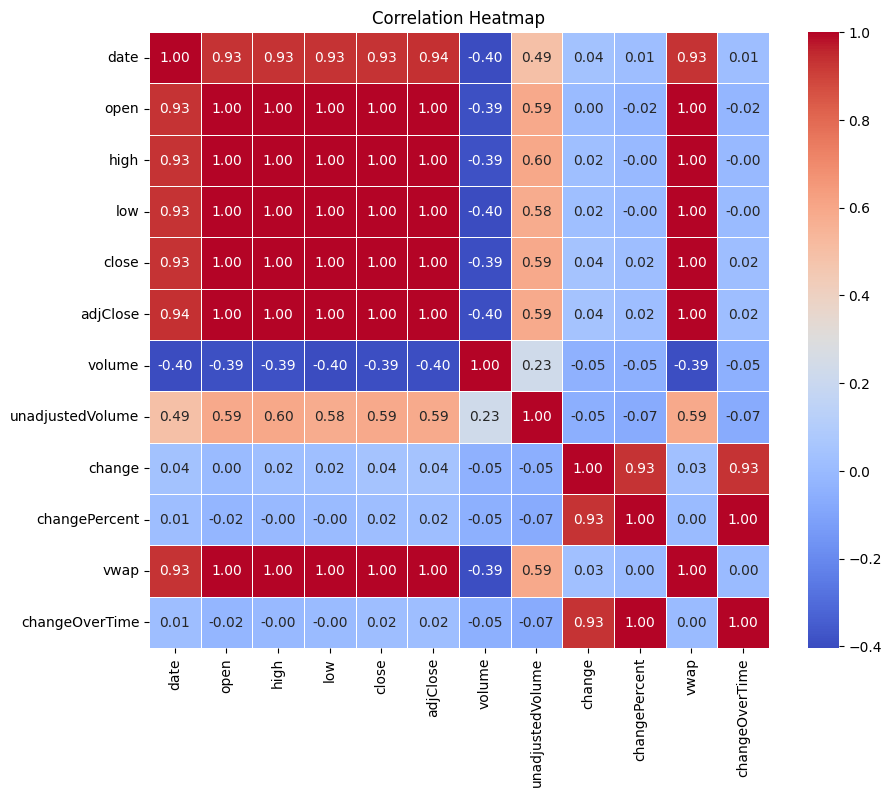

Correlation with Target Variable:
open                1.000000
high                0.999679
vwap                0.999622
low                 0.999613
close               0.999172
adjClose            0.999119
date                0.931200
unadjustedVolume    0.591784
volume              0.392411
changePercent       0.022124
changeOverTime      0.022124
change              0.000295
Name: open, dtype: float64
Best Features to Analyze the Data:
['high', 'vwap', 'low']


In [631]:
# Convert 'Date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

df.drop("label", axis=1, inplace=True)

# Compute the correlation matrix
correlation_matrix = df.corr()

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=ax)

# Set the title
ax.set_title('Correlation Heatmap')

# Display the heatmap
plt.show()

# Select the target variable
target_variable = 'open'

# Calculate the correlation between each feature and the target variable
correlation_with_target = correlation_matrix[target_variable].abs().sort_values(ascending=False)

# Print the correlation with the target variable
print("Correlation with Target Variable:")
print(correlation_with_target)

# Select the top-k features with the highest absolute correlation coefficients
k = 3
best_features = correlation_with_target[1:k+1].index.tolist()

# Print the best features
print("Best Features to Analyze the Data:")
print(best_features)

Conclusions
 - For featurs with strong correlation with the prediction ('open') feature we will assume that they will be the most important features to affect and contribute our modeling of the data set in the next part. Particularly, the features '' and '', that we can see from the heatmap.
 - We can also see a very strong correlation between features such as 'ChangePercent' and 'ChangeOverTime'. That is because they're basically a manipulation of the same feature ('Change'). In our PreProcessing part, we'll reduce the number of features to lower the complexity of our ML module.

# Preprocessing  

Now, we'll deep dive into the data and try to figure out how to deal with outliers, if the data is standardized, how to deal with missing data, how to compute categorial features into our models, addition of new features if needed and trying to reduce the dimensionality of the data to make our models less complex while explaining as much of the dataset's variation as possible.

We want to see the affect on the opening price by percentiles, so we'll work on the log of the price as our predicted value.

In this part we'll also divide our dataset into train data and test data randomly. We're taking this course of action so we can see how well our unsupervised modules preform at making opening prices predictions.

In [632]:
#df['log_price'] = np.log(df['open'])
#df.drop('open', axis=1, inplace=True)

Spliting the data into train data and test data for our prediction

In [633]:
#test_data, train_data = train_test_split(df.copy(), test_size = 0.8, random_state= 42, shuffle=True)
train_data = df
#test_data = df.iloc[int(len(df) * 0.9):]

Removing the prediction feature - log_opening_price, from the test dataset, and save it as a new variable.
We do this in order to compare our results of the prediction log_opening_price to the actual log_opening_price of the test dataset at the end of the Modeling section.

In [634]:
#actual_test_log_price = pd.DataFrame(test_data["log_price"])
#test_data.drop("log_price", axis=1, inplace=True)
#train_data.shape

The dataset that we chose randomly has  observations and  features. Therefore, because it's relatively big, this train dataset is indeed representative and canhelp us make strong predictions with regards to the opening price of the stock in the future (if it will rise, fall or keep a relatively stable price inside a "safety zone" that will be determind later on).

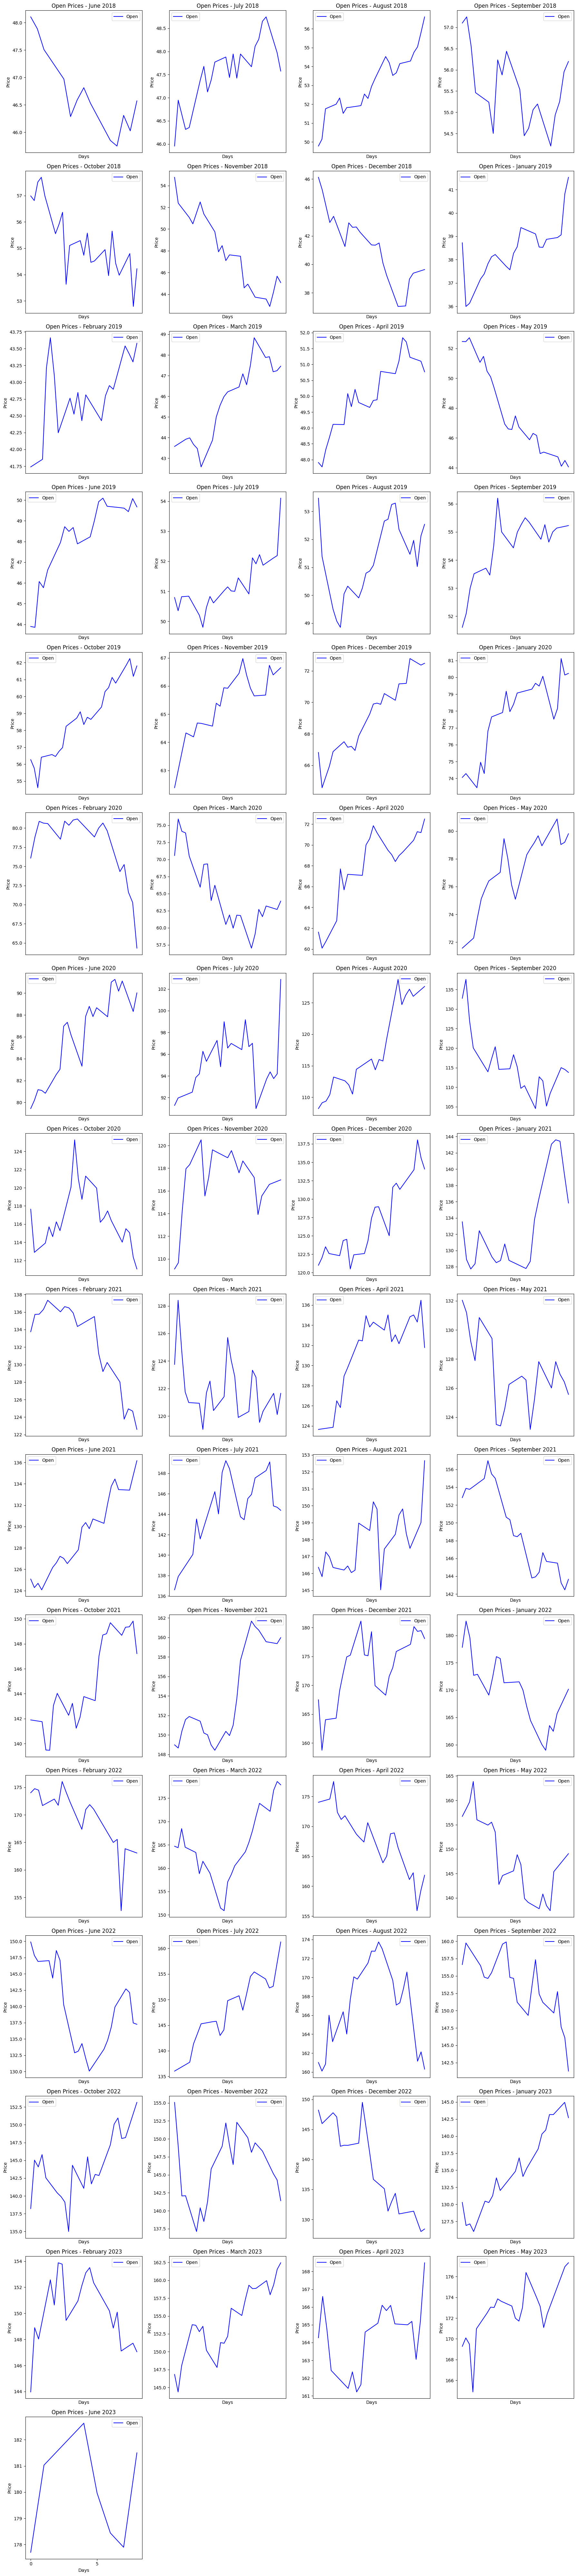

In [635]:
# Convert 'date' column to datetime type
train_data['date'] = pd.to_datetime(train_data['date'])

# Group data by month
grouped_data = train_data.groupby(pd.Grouper(key='date', freq='M'))

# Calculate the number of rows and columns for subplots
num_months = len(grouped_data)
num_cols = 4  # Four subplots in each row

# Calculate the number of rows needed based on the number of subplots
num_rows = (num_months + num_cols - 1) // num_cols

# Set up the figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

# Iterate over the grouped data and plot 'open' and 'close' prices for each month
for i, (month, group) in enumerate(grouped_data):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    days = (group['date'] - group['date'].min()).dt.days
    ax.plot(days, group['open'], color='blue', label='Open')

    ax.set_title(f"Open Prices - {month.strftime('%B %Y')}")
    ax.set_xlabel('Days')
    ax.set_ylabel('Price')
    ax.legend()

    # Hide x-axis ticks for all but the bottom row
    if row != num_rows - 1:
        ax.set_xticks([])
    else:
        ax.set_xticks(range(days.min(), days.max() + 1, 5))

# Hide any unused subplots
for i in range(num_months, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

### Dealing with outliers

In the previous part we noticed some outliers in some of the features by reviewing the histograms and boxplots. Now we will handle them by removing extreme values that can have an unproportionate effect on our modules

Our way of doing that will be by changing the top and bottom percentiles, which we think will eliminate most of the unwanted values while not changing too many observations

Step 1: Identifying Outliers using np.diff

In [636]:
# Calculate the differences between consecutive open prices, excluding the first date
train_data['price_diff'] = np.diff(train_data['open'], prepend=train_data['open'].iloc[0])

# Calculate the lower and upper percentiles for outliers
lower_percentile = np.percentile(train_data['price_diff'], 1)
upper_percentile = np.percentile(train_data['price_diff'], 99)

# Identify outliers based on the percentiles
outliers = train_data.iloc[:-1][(train_data['price_diff'] < lower_percentile) | (train_data['price_diff'] > upper_percentile)]

C:\Users\niroe\AppData\Local\Temp\ipykernel_3308\2057737182.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = train_data.iloc[:-1][(train_data['price_diff'] < lower_percentile) | (train_data['price_diff'] > upper_percentile)]


Step 2: Dealing with Outliers using Moving Average

In [637]:
# Calculate the weighted moving average of log_price with a 4-observation window
weights = [0.05, 0.15, 0.25, 0.55]  # Example weights for the 4-observation window

window_size = 4
train_data['weighted_avg'] = np.nan

for i in range(window_size, len(train_data)):
    window_values = train_data.iloc[i - window_size:i, train_data.columns.get_loc('open')]

    if len(window_values) > 0:
        weighted_avg = np.sum(window_values * weights) / np.sum(weights)
        train_data.loc[i, 'weighted_avg'] = weighted_avg

# Update the log_price of outliers with the weighted moving average values
train_data.loc[outliers.index, 'open'] = train_data.loc[outliers.index, 'weighted_avg']

# Interpolate missing values in log_price
train_data['open'].interpolate(method='linear', inplace=True)

# Drop the 'weighted_avg' column
train_data.drop('weighted_avg', axis=1, inplace=True)
train_data.drop('price_diff', axis=1, inplace=True)

Viewing the changes:

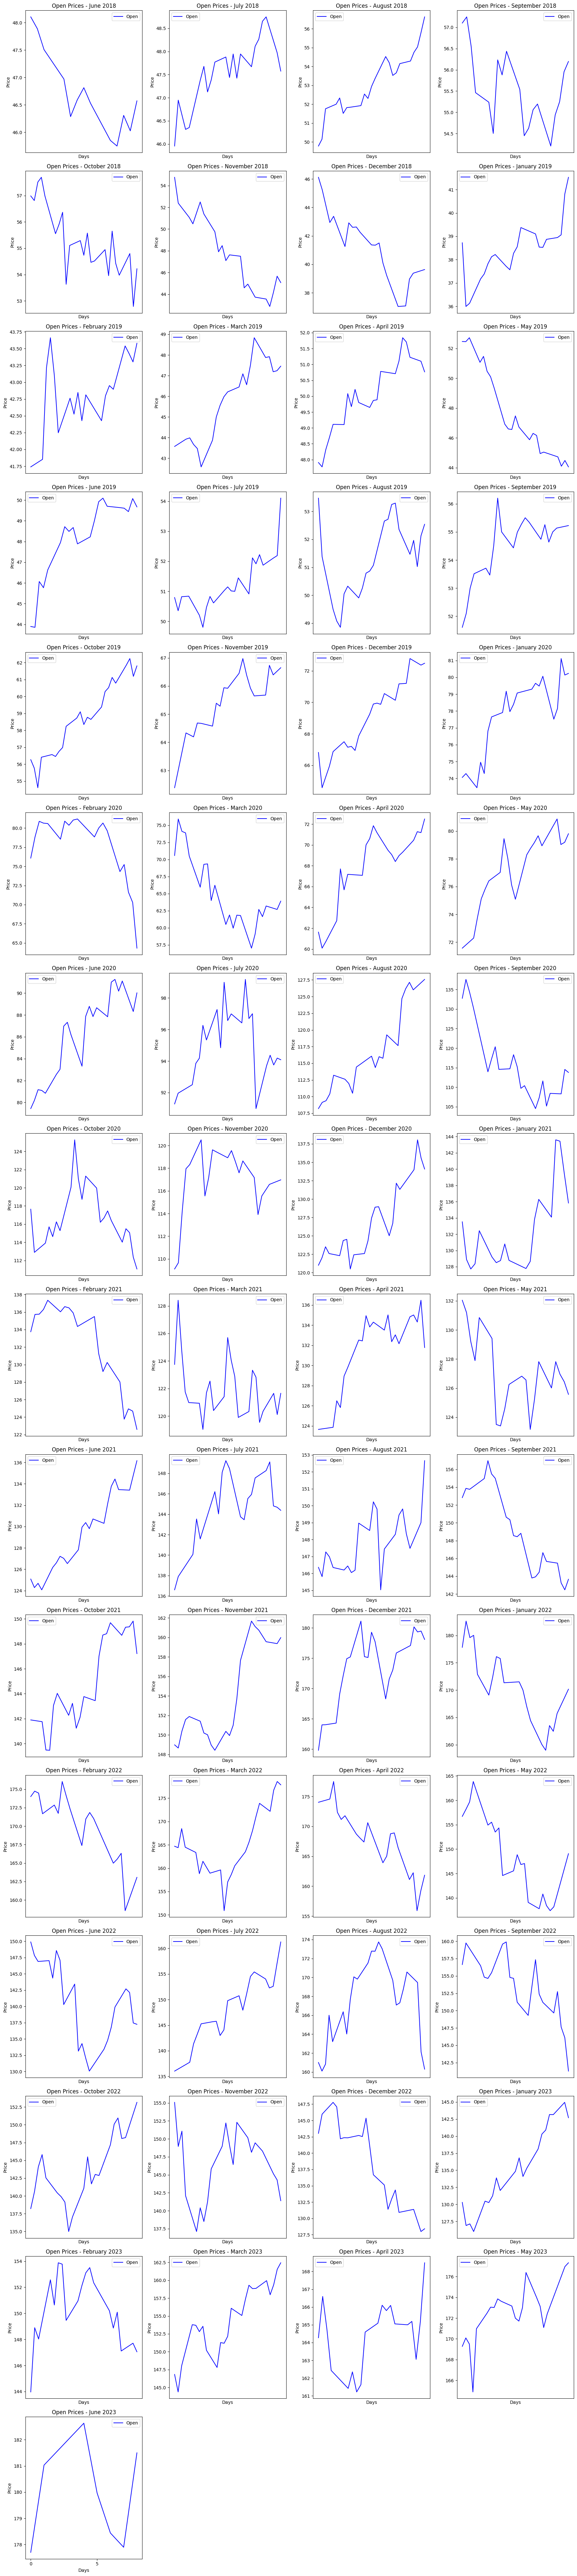

In [638]:
# Group data by month
grouped_data = train_data.groupby(pd.Grouper(key='date', freq='M'))

# Calculate the number of rows and columns for subplots
num_months = len(grouped_data)
num_cols = 4  # Four subplots in each row

# Calculate the number of rows needed based on the number of subplots
num_rows = (num_months + num_cols - 1) // num_cols

# Set up the figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

# Iterate over the grouped data and plot 'open' and 'close' prices for each month
for i, (month, group) in enumerate(grouped_data):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    days = (group['date'] - group['date'].min()).dt.days
    ax.plot(days, group['open'], color='blue', label='Open')

    ax.set_title(f"Open Prices - {month.strftime('%B %Y')}")
    ax.set_xlabel('Days')
    ax.set_ylabel('Price')
    ax.legend()

    # Hide x-axis ticks for all but the bottom row
    if row != num_rows - 1:
        ax.set_xticks([])
    else:
        ax.set_xticks(range(days.min(), days.max() + 1, 5))

# Hide any unused subplots
for i in range(num_months, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

As we can see by the plots, due to us 'flattening' the outliers, the open prices have a smaller range of values<br>As a result, the plots now have a 'smoother' line

### Dealing with overlaping features

As we can see from our data exploration, the data contains some overlaping features. In this section we'll drop unnecessary features. This will help lower the complexity of the ML modules we'll use later on while maintaining maximum explanatory power of the variable we want to predict in our models.

The next function takes a categorial feature and turnes it into a set of dummy variables:

* Turning 'day', 'month' and 'year' into dummy variables

In [639]:
#train_data, test_data = Get_Dummies('day', 'log_price', train_data, test_data)
#train_data, test_data = Get_Dummies('month', 'log_price', train_data, test_data)
#train_data, test_data = Get_Dummies('year', 'log_price', train_data, test_data)

Before dealing with dimentionality reduction and normalization, we will devide the dataset into x train, y train and x test:

* חלוקה לסך המשתנים ולמשתנה לחיזוי עבור סט האימון וסט המבחן

In [640]:
left_columns = train_data.iloc[:, :1]
right_columns = train_data.iloc[:, 1:]
X_train = pd.concat([left_columns, right_columns], axis=1)
y_train = train_data.iloc[:,1]
#X_test = test_data.iloc[:,:].values

In [641]:
features_train = X_train
#features_train.drop('log_price', axis=1, inplace=True)

After these changes, let's see how our train dataset looks like:

In [642]:
train_data_features = np.array(features_train.columns)
print(f"Train data features: {train_data_features}")

Train data features: ['date' 'open' 'high' 'low' 'close' 'adjClose' 'volume' 'unadjustedVolume'
 'change' 'changePercent' 'vwap' 'changeOverTime']


Dropping the date column for the dimension reduction and saving it for later use

In [643]:
save_the_date_train = X_train.iloc[:, 0]
X_train = X_train.iloc[:, 1:]
#save_the_date_test = X_test[:, 0]
#X_test = X_test[:, 1:]
train_data_features = train_data_features[1:]
test_data_features = test_data_features[1:]

In [644]:
# train_data_features
# df = X_train.copy()
# X_train.columns
# cols_to_standardize = ''
# df[] = scaler.fit_transform(df[cols_to_standardize])

### Dealing with Standardization

In our data, some of the features are normalized and some aren't. Data normalization is the method of organizing data to appear similar across all records and fields. Performing so always results in getting higher quality data and better results. This process basically includes eliminating unstructured data and duplicates in order to ensure logical data storage.

Normalizing all features to be between 0 and 1 by reducing the minimal value and dividing by the max (according to the distributions found in the train dataset):

In [645]:
scaler = StandardScaler()
X_train_normalize = scaler.fit_transform(X_train)
train_data_normalize = scaler.fit_transform(X_train_normalize)
#X_test_normalize = scaler.fit_transform(X_test)


In [646]:
X_train_normalize = pd.DataFrame(X_train_normalize)
#X_test_normalize = pd.DataFrame(X_test_normalize)
add_to_x_later = X_train_normalize.iloc[:, :1]
X_train_normalize = X_train_normalize.iloc[:, 1:]
#add_to_test_later = X_test_normalize.iloc[:, :1]
#X_test_normalize = X_test_normalize.iloc[:, 1:]

### Dimentionality reduction process


### Forward Selection

Forward selection is an iterative method in which we start with having no feature in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model.

our "punishment" method in which we'll evaluate the number of features will be Mallow's C_p.
In statistics, Mallows's Cp is used to assess the fit of a regression model that has been estimated using ordinary least squares. It is applied in the context of model selection, where a number of predictor variables are available for predicting some outcome, and the goal is to find the best model involving a subset of these predictors. A small value of Cp means that the model is relatively precise.

$ C_p= MSE+2\frac{d+1}{n}\hat{\sigma}^2$ <br><br>
Where : $ \hat{\sigma}^2 = \frac{RSS_{all features}}{n-\#features-1} $,   and $\#features$ is the number of all features

We'll evaluate our Forward Feature Selection using Mallow's C_p

![https://slideplayer.com/slide/4646748/15/images/7/Forward+Selection+%28wrapper%29.jpg](https://slideplayer.com/slide/4646748/15/images/7/Forward+Selection+%28wrapper%29.jpg)

Feature Selection with Linear Regression:

In [647]:
X_train_normalize = X_train_normalize.values

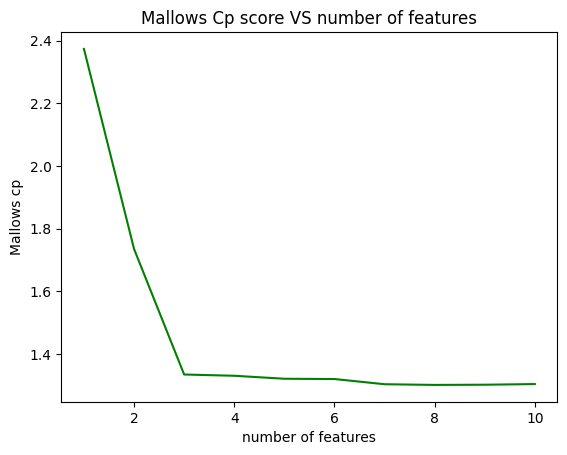

number of selected features by forward: 8
best features by forward: [0, 1, 2, 4, 5, 6, 8, 9]


In [648]:
best_features_list = forward_selection(X_train_normalize, y_train)
print(f'number of selected features by forward: {len(best_features_list)}')
print(f'best features by forward: {best_features_list}')

In [649]:
# train_data_features

In [650]:
print(f"The features that remain in our analysis after the forward selection methods: {list(train_data_features[best_features_list])}")

The features that remain in our analysis after the forward selection methods: ['open', 'high', 'low', 'adjClose', 'volume', 'unadjustedVolume', 'changePercent', 'vwap']


the selected features are: high, close, volume, change, vwap, changeOverTime

### PCA
The function will return the minimal group of components, which explain more than (100*0.95)% of the variance.

In [651]:
def get_principal_components(X: np.array) -> np.array:
    pca = PCA(n_components = X.shape[1], whiten=True)
    pca.fit_transform(X)
    plt.bar(range(1, len(pca.explained_variance_ratio_)+1),np.cumsum(pca.explained_variance_ratio_))
    plt.title("Cumulitive Explained variance per eigenvector")
    plt.xlabel("number of features")
    plt.ylabel("percentage")
    plt.show()

    pca = PCA(0.95, whiten=True)
    data = pca.fit_transform(X)
    print("For explained variance:", 0.95, "number of components/dimentions:", data.shape[1])
    return pca.components_

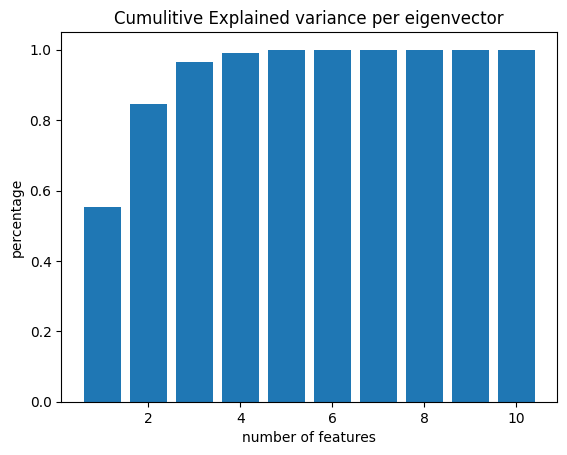

For explained variance: 0.95 number of components/dimentions: 3


In [652]:
best_components_list = get_principal_components(X_train_normalize)

### Comparison between forward selection and PCA

In [653]:
# calculate the test MSE for each reduced dataset
X_forward_reduced_train = X_train_normalize[:, best_features_list]
# get components based on train set:
X_pca_train = np.dot(X_train_normalize, best_components_list.T)
#x_pca_test = np.dot(X_test, train_components.T)

In [654]:
X_forward_reduced_train = pd.DataFrame(X_forward_reduced_train)
X_forward_reduced_train
#X_forward_reduced_train = X_forward_reduced_train.rename(columns=dict(zip(X_forward_reduced_train.columns, train_data_features)))

0         1         2         3         4         5         6   
0    -1.315230 -1.304115 -1.315539 -0.440517 -1.096244 -0.286149 -1.311026  \
1    -1.322278 -1.305327 -1.314995 -0.442587 -1.096952 -0.156434 -1.314509   
2    -1.329865 -1.316122 -1.325658  2.489948 -0.093571 -0.215274 -1.324524   
3    -1.334922 -1.321961 -1.326202 -0.671084 -1.175133  0.058867 -1.326919   
4    -1.350472 -1.342615 -1.342795  0.432469 -0.797547  0.017412 -1.345207   
...        ...       ...       ...       ...       ...       ...       ...   
1252  1.627475  1.569319  1.554877  0.202318  1.413095 -1.687611  1.611783   
1253  1.523503  1.555990  1.546825 -0.837311 -0.015289 -0.459995  1.537107   
1254  1.546961  1.553567  1.516577 -0.890332 -0.087931 -0.387782  1.536018   
1255  1.538998  1.556651  1.576421 -1.104810 -0.381365  1.374744  1.555395   
1256  1.568914  1.626491  1.585560 -1.429333 -0.454172 -0.328942  1.599591   

             7  
0    -0.641915  
1    -0.321280  
2    -0.471072  
3     0.220801  
4     0.118248  
...        ...  
1252 -1.137298  
1253 -0.339145  
1254 -0.293144  
1255  0.886057  
1256 -0.250718  

[1257 rows x 8 columns]

#### Results
Using these new datasets, we will now print the train mse of each model:

In [655]:
# Create and fit the linear regression models
linear_reg_forward = LinearRegression().fit(X_forward_reduced_train, y_train)
linear_reg_pca = LinearRegression().fit(X_pca_train, y_train)

# Predict the target variable for the training set
y_pred_train_forward = linear_reg_forward.predict(X_forward_reduced_train)
y_pred_train_pca = linear_reg_pca.predict(X_pca_train)

# Predict the target variable for the test set
#y_pred_test_forward = linear_reg_forward.predict(X_forward_reduced_test)
#y_pred_test_pca = linear_reg_pca.predict(X_pca_test)

train_mse_forward = mean_squared_error(y_train, y_pred_train_forward)
#test_mse_forward = mean_squared_error(y_test, reg_forward_predict_test)
train_mse_pca = mean_squared_error(y_train, y_pred_train_pca)
#test_mse_pca = mean_squared_error(y_test, reg_pca_predict_test)

print(f'MSE train - PCA: {round(train_mse_pca,4)}')
#print(f'MSE test - PCA: {round(test_mse_pca,4)}')
print(f'MSE train - forward: {round(train_mse_forward,4)}')
#print(f'MSE test - forward: {round(test_mse_forward,4)}')

MSE train - PCA: 10.7404
MSE train - forward: 1.2834


Choosing the best method to reduce dimensionality -

In our case, forward selection got better results (smaller train MSE), using only 3 more features, having the original meaning of the features (compare to PCA that probably lost a lot of information that causes the tradeoff between information loss and dimensionality reduction to tends more to the side of information loss than the Forward selection). Therefor it seems better to use forward selection for this dataset, if we were to use Logistic Regression <br>

It is also important mentioning that we used a forward selection algorithm based on Logistic Regression Model for every one of our 4 Models that we will implement in the next section. The reason is because the of the high running time that takes for implement feature selection for every one of our models. We also want to mention that we are aware that if we would implement forward selection for every model separately (and not based only on the Logistic Regression) obviously we would get better results on the other 3 models (apart from the Logistic Regression model)

In [656]:
#X_test_normalize.shape

In [657]:
best_features_list

[0, 1, 2, 4, 5, 6, 8, 9]

In [658]:
#X_train_before_split = X_forward_reduced_train
#y_train_before_split = y_train.copy()
data_reduction = df.iloc[:, best_features_list]
#X_Test = X_test_normalize[:, best_features_list]

In [659]:
#pd.DataFrame(X_Test)

## Manipulation of existing features

Turning the train and test data back to pandas and adding back the date column

In [660]:
X_train = pd.DataFrame(X_forward_reduced_train)
X_train['date'] = save_the_date_train
#X_Test = pd.DataFrame(X_Test)
#X_Test['date'] = save_the_date_test

The following function converts numbers from scientific notation to regular notation:

* Adding the 'day', 'month' and 'year' categorical variables to the train data, then dropping the 'date' column

In [661]:
X_train['day'] = X_train['date'].dt.day
X_train['month'] = X_train['date'].dt.month
X_train['year'] = X_train['date'].dt.year
X_train = X_train.drop('date', axis=1)


In [662]:
y_train = pd.DataFrame(y_train)
#train_new = pd.concat([X_train,y_train], axis=1)


* Adding the 'day', 'month' and 'year' categorical variables to the test data, then dropping the 'date' column

In [663]:
#X_Test['day']    = X_Test['date'].dt.day
#X_Test['month']  = X_Test['date'].dt.month
#X_Test['year']  = X_Test['date'].dt.year
#X_Test          = X_Test.drop('date', axis=1)

In [664]:
best_features_list = list(train_data_features[1:])

In [665]:
X_train_normalize = pd.DataFrame(X_train_normalize)
X_train = X_train.rename(columns=dict(zip(X_train_normalize.columns, best_features_list)))
#X_Test = X_Test.rename(columns=dict(zip(X_Test.columns, best_features_list)))
#X_train.rename(columns={0: 'open'}, inplace=True)

In [666]:
X_train = pd.concat([add_to_x_later, X_train], axis=1)
X_train.rename(columns={0: 'open'}, inplace=True)
#X_Test = pd.concat([add_to_test_later, X_Test], axis=1)
#X_Test.rename(columns={0: 'open'}, inplace=True)
# X_train_normalize
# train_data_normalize = scaler.fit_transform(X_train_normalize )
# X_test_normalize = scaler.fit_transform(X_test)

## Label Definition

For our project we wanted to take a different approach that might bring insights to a larger audience. Instead of predicting the stock's price, which will be much less accurate, we want to predict the overall behavior of the stock by trying to estimate weather the price will go up, go down or stay within a window created by thresholds <br>

Due to the data we have on the stock , and mainly due to the information we don't have (earning or quarterly reports, media coverage about the company etc). Therefor, we would try to analyze the price with mathematic models and based on recent information we have on the stock.

In this section, we'll determine an initial window consisting of a lower and upper threshold values that will be calculated where the average will be today's price and the bound are 0.5 standard deviation to each direction by moving average of the past 30 days. This course of action helps us predict abnormal behaviors of the stock and will make it easier to classify

In the section of running and evaluating ML models, we'll also run a grid-search on a number of ways to create these thresholds and compare the results between them to get optimal results

In [667]:
# Calculate the moving average of the past 30 days
#X_train['moving_average'] = X_train['log_price'].rolling(window=30).mean()
#X_train['moving_average'] = X_train['open'].rolling(window=30).mean()
# Calculate the standard deviation of the past 30 days
#X_train['standard_deviation'] = X_train['log_price'].rolling(window=30).std()
#X_train['standard_deviation'] = X_train['open'].rolling(window=30).std()

# Calculate the lower and upper thresholds
#X_train['lower_threshold'] = X_train['moving_average'] - (0.5 * X_train['standard_deviation'])
#X_train['upper_threshold'] = X_train['moving_average'] + (0.5 * X_train['standard_deviation'])

# Get today's price and average
#today_price = X_train['open'].iloc[-1]
#today_average = X_train['moving_average'].iloc[-1]

#print("Today's Price: $", today_price)
#print("Today's Moving Average: $", today_average)
#print("Lower Threshold: $", X_train['lower_threshold'].iloc[-1])
#print("Upper Threshold: $", X_train['upper_threshold'].iloc[-1])
#print("Window size = ",X_train['upper_threshold'].iloc[-1] - X_train['lower_threshold'].iloc[-1])


In [668]:
#X_train['label'] = 0  # Initialize 'label' column to 0

#X_train.loc[X_train['open'] < X_train['lower_threshold'], 'label'] = -1
#X_train.loc[X_train['open'] > X_train['upper_threshold'], 'label'] = 1

# dror acc

In [669]:
def weighted_accuracy(y_true, y_pred):
    # Total number of samples
    L = len(y_true)
    # Number of samples where y_i = 0
    S = np.sum(np.array(y_true) == 0)

    # Weight for class 0
    weight_0 = (L - S) / L if S != 0 else 1

    # Initialize variables for correct classifications
    correct_classifications = 0

    # Iterate through true and predicted labels
    for yt, yp in zip(y_true, y_pred):
        # If the labels match
        if yt == yp:
            # If the label is 0, apply the custom weight
            if yt == 0:
                correct_classifications += weight_0
            # If the label is 1 or -1, apply a weight of 1
            else:
                correct_classifications += 1

    # Compute the final weighted accuracy
    accuracy = correct_classifications / L

    return accuracy

# dror func

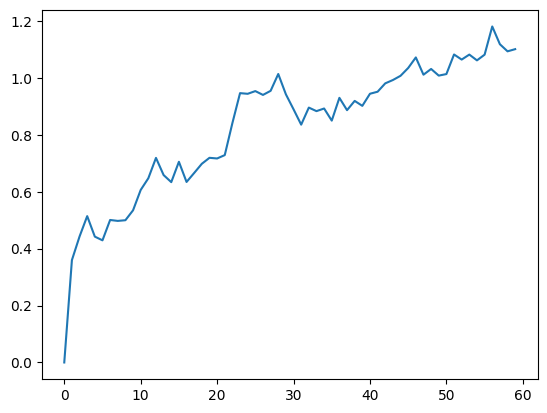

In [670]:
labels = X_train['open']
d = np.diff(labels)
np.max(d)
labels
def find_th_max(data_ts , h):
  max_jump = 0
  for i in range(len(data_ts) - h ):
    diff_h = np.abs(data_ts[i+h] - data_ts[i])
    if diff_h > max_jump:
      max_jump = diff_h
  return max_jump
# labels.values
lst_th = np.zeros(60)

for h in range(60):
  lst_th[h] = find_th_max (labels.values , h)

plt.plot(lst_th)

In [671]:
run_flag = 0
if run_flag:
  cols = X_train.columns
  for col in cols:
    values = X_train[col].values[::-1]
    X_train[col] = values

In [672]:
X_train

open      high       low     close  adjClose    volume   
0    -1.304112 -1.315230 -1.304115 -1.315539 -0.440517 -1.096244  \
1    -1.308845 -1.322278 -1.305327 -1.314995 -0.442587 -1.096952   
2    -1.317113 -1.329865 -1.316122 -1.325658  2.489948 -0.093571   
3    -1.328808 -1.334922 -1.321961 -1.326202 -0.671084 -1.175133   
4    -1.343713 -1.350472 -1.342615 -1.342795  0.432469 -0.797547   
...        ...       ...       ...       ...       ...       ...   
1252  1.622925  1.627475  1.569319  1.554877  0.202318  1.413095   
1253  1.564939  1.523503  1.555990  1.546825 -0.837311 -0.015289   
1254  1.531758  1.546961  1.553567  1.516577 -0.890332 -0.087931   
1255  1.519899  1.538998  1.556651  1.576421 -1.104810 -0.381365   
1256  1.598338  1.568914  1.626491  1.585560 -1.429333 -0.454172   

      unadjustedVolume    change  changePercent  day  month  year  
0            -0.286149 -1.311026      -0.641915   13      6  2018  
1            -0.156434 -1.314509      -0.321280   14      6  2018  
2            -0.215274 -1.324524      -0.471072   15      6  2018  
3             0.058867 -1.326919       0.220801   18      6  2018  
4             0.017412 -1.345207       0.118248   19      6  2018  
...                ...       ...            ...  ...    ...   ...  
1252         -1.687611  1.611783      -1.137298    5      6  2023  
1253         -0.459995  1.537107      -0.339145    6      6  2023  
1254         -0.387782  1.536018      -0.293144    7      6  2023  
1255          1.374744  1.555395       0.886057    8      6  2023  
1256         -0.328942  1.599591      -0.250718    9      6  2023  

[1257 rows x 12 columns]

something dror did

In [673]:
#scaler = StandardScaler()
#best_features_list1 = train_data_features[best_features_list].tolist()
#best_features_list1
##
#x_data_train=  X_train[best_features_list1]
#X_open_normalize = scaler.fit_transform(np.array(X_train['open']).reshape(-1,1))
#X_train['x_open'] = X_open_normalize

#x_data_train

In [674]:
# for every H we have multiple thresholds
#acc_h_th = {}
#3: [acc1 , acc2 , acc3,..., ]

# acc_h_th = {}

# key = h




In [675]:
#th_step  = 1
#th_max =  5

#th_values = np.arange(0,th_max,th_step)
#th_values

# [ 1.2 , 1.15, 1,17, 1.9 ]

In [676]:
X_train

open      high       low     close  adjClose    volume   
0    -1.304112 -1.315230 -1.304115 -1.315539 -0.440517 -1.096244  \
1    -1.308845 -1.322278 -1.305327 -1.314995 -0.442587 -1.096952   
2    -1.317113 -1.329865 -1.316122 -1.325658  2.489948 -0.093571   
3    -1.328808 -1.334922 -1.321961 -1.326202 -0.671084 -1.175133   
4    -1.343713 -1.350472 -1.342615 -1.342795  0.432469 -0.797547   
...        ...       ...       ...       ...       ...       ...   
1252  1.622925  1.627475  1.569319  1.554877  0.202318  1.413095   
1253  1.564939  1.523503  1.555990  1.546825 -0.837311 -0.015289   
1254  1.531758  1.546961  1.553567  1.516577 -0.890332 -0.087931   
1255  1.519899  1.538998  1.556651  1.576421 -1.104810 -0.381365   
1256  1.598338  1.568914  1.626491  1.585560 -1.429333 -0.454172   

      unadjustedVolume    change  changePercent  day  month  year  
0            -0.286149 -1.311026      -0.641915   13      6  2018  
1            -0.156434 -1.314509      -0.321280   14      6  2018  
2            -0.215274 -1.324524      -0.471072   15      6  2018  
3             0.058867 -1.326919       0.220801   18      6  2018  
4             0.017412 -1.345207       0.118248   19      6  2018  
...                ...       ...            ...  ...    ...   ...  
1252         -1.687611  1.611783      -1.137298    5      6  2023  
1253         -0.459995  1.537107      -0.339145    6      6  2023  
1254         -0.387782  1.536018      -0.293144    7      6  2023  
1255          1.374744  1.555395       0.886057    8      6  2023  
1256         -0.328942  1.599591      -0.250718    9      6  2023  

[1257 rows x 12 columns]

In [553]:
# horizons = list(h_acc.keys())
# accuracy = list(h_acc.values())

# plt.plot(horizons, accuracy)

# # Add labels and title
# plt.xlabel('horizons')
# plt.ylabel('accuracy')
# plt.title('beautiful headline')

# # Display the plot
# plt.show()

## Running & evaluating ML modules

Our ML modules will be Multi Layer Perceptron, Support Vector Machine, Random Forrest and Reaccuring Neural Network.

In this part we'll run our modules, and if possible, try to understand the importance of features in our data to the label prediction.

We will be running them over the train dataset and try to improve them as much as possible, as well as evaluating them with time-series cross validation process as well as checking their performance using Accuracy score for every module.

We will also try to explain if our algorithm is overfitted, and if so, how can we solve (at least partially) this problem.

In this part, we'll chose our module for the test dataset prediction, based on which one of them preformed the best (highest Accuracy score).

In [677]:
X_train_model = X_train.iloc[:,:-4]

#### MLP

Multilayer Perceptron is a neural network where the mapping between inputs and output is non-linear.
A Multilayer Perceptron has input and output layers, and one or more hidden layers with many neurons stacked together.
While a Perceptron in the neuron must have an activation function that imposes a threshold, like ReLU or sigmoid, neurons in a Multilayer Perceptron can use any arbitrary activation function.

![https://miro.medium.com/max/1100/1*MF1q2Q3fbpYlXX8fZUiwpA.webp](https://miro.medium.com/max/1100/1*MF1q2Q3fbpYlXX8fZUiwpA.webp)

In [ ]:
y_train

In [ ]:
# Example for spesific W , H ,
X, Y = X_train_model , y_train.values
W, H , th_model = 5 , 3 , 5 ## choose paraneters/ run it in grid search loop
X_train_W , y_train_W = sliding_window_th(X , Y , window_size = W , horizon = H, th = th_model)
X_train_W = X_train_W.reshape(X_train_W.shape[0], -1)

np.shape(X_train_W ) , np.shape(y_train_W)


In [555]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}



# Create an MLP Regressor
mlp = MLPClassifier(max_iter=1000)

# Create a GridSearchCV instance
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1)

# Fit the grid search to your data
grid_search.fit(X_train_W, y_train_W)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'sgd'}
Best Score: 0.7714285714285715


In [569]:
## full example: grid search over W , H , th
#W_max  =  8
#W_step =  3 # min W = 1
H_max  =  14
H_step =  1 # min H = 1
#th_max =  5
#th_step = 0.5
y_th_arr = []
X_arr_W    = []
Y_arr_H    = []
Y_arr_H_step    = []
acc_arr = []
y_th_arr_no_penalty = []
Y_arr_H_no_penalty    = []
Y_arr_H_no_penalty_step    = []
acc_arr_no_penalty = []
labels = y_train['open']
max_acc = 0
values = []
h_acc = {}
h_acc_lst = []

th_dict = {}

### Optimize over Validation dataset: Creating grid arrays
for h in range(1,H_max,H_step):
  W_max = 2 * H_max
  W_step = W_max // 7
  th_max = int(find_th_max (labels.values, h)) + 4
  th_step = max(th_max // 5, 1)
  values_ = []
  max_acc_ = 0
  for th in range(0,th_max,th_step):
    th_acc = []
    th_ac_for_dict = []
    
    for w in range(1, W_max, W_step):
      #print ('h:' , h,'th val:' , th, 'w:', w)
      X, y = sliding_window_th(X_train_model, labels, w, h, th)

      # Split the data into training and validation sets
      X_Train, X_val, y_Train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

      num_samples, window_size, num_features = X_Train.shape
      X_Train_flat = X_Train.reshape(num_samples, -1)  # Flatten each window sequence

      num_samples, window_size, num_features = X_val.shape
      X_val_flat = X_val.reshape(num_samples, -1)  # Flatten each window sequence
      # Create and train the MLP classifier
      model = MLPClassifier(activation = 'tanh', alpha = 0.001, hidden_layer_sizes = (100,), learning_rate = 'adaptive', solver = 'sgd')

      # Now use X_Train_flat for training
      model.fit(X_Train_flat, y_Train)

      # Make predictions on the validation set
      y_pred = model.predict(X_val_flat)

      # Calculate and store the accuracy score
      accuracy = weighted_accuracy(y_val, y_pred)
      accuracy_no_penalty = accuracy_score(y_val, y_pred)
      #print(accuracy)
      if accuracy > max_acc:
        values.append([h, w, th, accuracy])
        max_acc = accuracy

      if accuracy_no_penalty > max_acc_:
        values_.append(accuracy_no_penalty)
        max_acc_ = accuracy_no_penalty

      # Store the results for each combination of W, H, th
      X_arr_W.append(w)
      Y_arr_H.append(h)
      y_th_arr.append(th)
      acc_arr.append(accuracy)
      if accuracy_no_penalty != 0:
        Y_arr_H_no_penalty.append(h)
        y_th_arr_no_penalty.append(th)
        acc_arr_no_penalty.append(accuracy_no_penalty)
      th_ac_for_dict.append(accuracy_no_penalty)
    th_acc.append(values_[-1])
    th_dict[th] = th_ac_for_dict

  h_acc[h] = th_acc
  h_acc_lst.append(th_acc)

  h_acc[h] = values_[-1]

th_values = np.arange(0,th_max,th_step)




c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

### Training the model according to the best parameters:

###Saving the trained model:

In [559]:
values[-1]

[13, 5, 0, 0.7321428571428571]

In [558]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110

    accuracy                           1.00       110
   macro avg       1.00      1.00      1.00       110
weighted avg       1.00      1.00      1.00       110



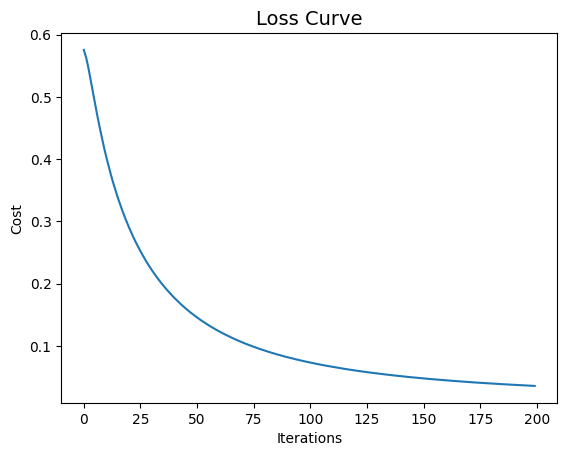

In [560]:
plt.plot(model.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [687]:
th_dict

{0: [0.7232142857142857,
  0.6875,
  0.7297297297297297,
  0.7117117117117117,
  0.7027027027027027,
  0.7090909090909091,
  0.6909090909090909],
 3: [0.9469026548672567,
  0.9469026548672567,
  0.9375,
  0.9464285714285714,
  0.9464285714285714,
  0.9459459459459459,
  0.9459459459459459],
 6: [0.9464285714285714,
  0.9464285714285714,
  0.9459459459459459,
  0.9459459459459459,
  0.9459459459459459,
  0.9363636363636364,
  0.9454545454545454],
 9: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 12: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 15: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 18: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 4: [0.9292035398230089,
  0.9196428571428571,
  0.9285714285714286,
  0.9285714285714286,
  0.9369369369369369,
  0.9369369369369369,
  0.9363636363636364],
 8: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 16: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 20: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [0.9285714285714286,
  0.9196428571428571,
  0.9196428571428571,
  0.9279279279279279,
  0.91891

# Needs to be adjusted to RNN

In [ ]:
x_h = [1,2,3,4,5,6,7]
for th in th_values:
  y_acc_th = th_dict[th]
  z = [y_acc_th]
  for index in range(len(z)):
    plt.plot(x_h,z[index] , label = th)

  plt.legend()

In [ ]:
y_th_arr_no_penalty

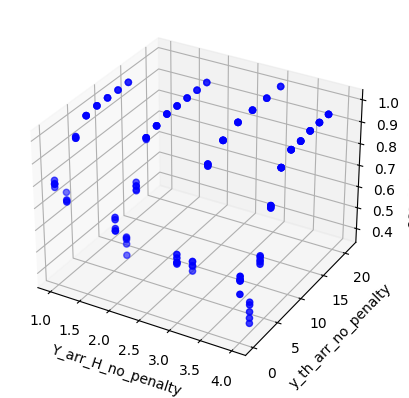

In [685]:
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(Y_arr_H_no_penalty, y_th_arr_no_penalty, acc_arr_no_penalty, c='b', marker='o')

# Set labels for the axes
ax.set_xlabel('Y_arr_H_no_penalty')
ax.set_ylabel('y_th_arr_no_penalty')
ax.set_zlabel('acc_arr_no_penalty')

# Show the plot
plt.show()

In [683]:
## full example: grid search over W , H , th
#W_max  =  8
#W_step =  3 # min W = 1
H_max  =  5
H_step =  1 # min H = 1
#th_max =  5
#th_step = 0.5
y_th_arr = []
X_arr_W    = []
Y_arr_H    = []
Y_arr_H_step    = []
acc_arr = []
y_th_arr_no_penalty = []
Y_arr_H_no_penalty    = []
Y_arr_H_no_penalty_step    = []
acc_arr_no_penalty = []
labels = y_train['open']
X_data = X_train.iloc[:,:-4]
max_acc = 0
values = []
h_acc = {}
h_acc_lst = []
best_h_th = []
### Optimize over Validation dataset: Creating grid arrays
for h in range(1,H_max,H_step):
  W_max = 5 * H_max
  W_step = W_max // 5
  th_max = int(find_th_max (labels.values, h))
  th_step = max(th_max // 7, 1)
  values_ = []
  max_acc_ = 0

  for th in range(0,th_max,th_step):
    th_acc = []
    max_acc_w = 0 
    w_best = 0 
    for w in range(1, W_max, W_step):
      print ('h:' , h,'th val:' , th, 'w:', w)
      X, y = sliding_window_th(X_data, labels, w, h, th)

      # Split the data into training and validation sets
      X_Train, X_val ,y_Train, y_val  =  train_test_split( X , y, test_size = 0.1, random_state=42, shuffle=False)

      num_samples, window_size, num_features = X_Train.shape
      X_Train_flat = X_Train.reshape(num_samples, -1)  # Flatten each window sequence

      num_samples, window_size, num_features = X_val.shape
      X_val_flat = X_val.reshape(num_samples, -1)  # Flatten each window sequence
      # Create and train the MLP classifier
      model = MLPClassifier(activation = 'tanh', alpha = 0.001, hidden_layer_sizes = (100,), learning_rate = 'adaptive', solver = 'sgd')

      # Now use X_Train_flat for training
      model.fit(X_Train_flat, y_Train)

      # Make predictions on the validation set
      y_pred = model.predict(X_val_flat)
      #### 
      
      # Calculate and store the accuracy score
      accuracy            =  weighted_accuracy(y_val, y_pred)
      accuracy_no_penalty =  accuracy_score(y_val, y_pred)
      acc_w               =  accuracy_no_penalty      
      #print(accuracy)
      if accuracy > max_acc:
        values.append([h, w, th, accuracy])
        max_acc = accuracy

      if accuracy > max_acc_:
        values_.append(accuracy)
        max_acc_ = accuracy

      # Store the results for each combination of W, H, th
      X_arr_W.append(w)
      Y_arr_H.append(h)
      y_th_arr.append(th)
      acc_arr.append(accuracy)

      if accuracy_no_penalty != 0:
        Y_arr_H_no_penalty.append(h)
        y_th_arr_no_penalty.append(th)
        acc_arr_no_penalty.append(accuracy_no_penalty)

      if max_acc_w < acc_w:
        max_acc_w = acc_w
        w_best    = w
    ### out of W loop
    best_h_th.append(( h, th , w_best , max_acc_w))  

        
    th_acc.append(values_[-1])

  h_acc[h] = th_acc
  h_acc_lst.append(th_acc)

  h_acc[h] = values_[-1]

th_values = np.arange(0,th_max,th_step)

h: 1 th val: 0 w: 1
h: 1 th val: 0 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 0 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 0 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 0 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 2 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 2 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 2 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 2 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 2 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 4 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 4 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 4 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 4 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 4 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 6 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 6 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 6 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 6 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 6 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 8 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 8 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 8 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 8 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 8 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 10 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 10 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 10 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 10 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 10 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 12 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 12 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 12 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 12 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 12 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 14 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 14 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 14 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 14 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 14 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 0 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 0 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 0 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 0 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 0 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 2 w: 1
h: 2 th val: 2 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 2 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 2 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 2 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 4 w: 1
h: 2 th val: 4 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 4 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 4 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 4 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 6 w: 1
h: 2 th val: 6 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 6 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 6 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 6 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 8 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 8 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 8 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 8 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 8 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 10 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 10 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 10 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 10 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 10 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 12 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 12 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 12 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 12 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 12 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 14 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 14 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 14 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 14 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 14 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 16 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 16 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 16 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 16 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 16 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 18 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 18 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 18 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 18 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 2 th val: 18 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 0 w: 1
h: 3 th val: 0 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 0 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 0 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 0 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 3 w: 1
h: 3 th val: 3 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 3 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 3 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 3 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 6 w: 1
h: 3 th val: 6 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 6 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 6 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 6 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 9 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 9 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 9 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 9 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 9 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 12 w: 1
h: 3 th val: 12 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 12 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 12 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 12 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 15 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 15 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 15 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 15 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 15 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 18 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 18 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 18 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 18 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 18 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 21 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 21 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 21 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 21 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 21 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 0 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 0 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 0 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 0 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 0 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 2 w: 1
h: 4 th val: 2 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 2 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 2 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 2 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 4 w: 1
h: 4 th val: 4 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 4 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 4 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 4 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 6 w: 1
h: 4 th val: 6 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 6 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 6 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 6 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 8 w: 1
h: 4 th val: 8 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 8 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 8 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 8 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 10 w: 1
h: 4 th val: 10 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 10 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 10 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 10 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 12 w: 1
h: 4 th val: 12 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 12 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 12 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 12 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 14 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 14 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 14 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 14 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 14 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 16 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 16 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 16 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 16 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 16 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 18 w: 1


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 18 w: 6


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 18 w: 11


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 18 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 4 th val: 18 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [684]:
best_h_th

[(1, 0, 6, 0.816),
 (1, 2, 1, 0.7222222222222222),
 (1, 4, 16, 0.9354838709677419),
 (1, 6, 1, 0.9920634920634921),
 (1, 8, 1, 1.0),
 (1, 10, 1, 1.0),
 (1, 12, 1, 1.0),
 (1, 14, 1, 1.0),
 (2, 0, 1, 0.7301587301587301),
 (2, 2, 6, 0.6),
 (2, 4, 6, 0.808),
 (2, 6, 6, 0.968),
 (2, 8, 1, 0.9841269841269841),
 (2, 10, 1, 1.0),
 (2, 12, 1, 1.0),
 (2, 14, 1, 1.0),
 (2, 16, 1, 1.0),
 (2, 18, 1, 1.0),
 (3, 0, 11, 0.648),
 (3, 3, 6, 0.552),
 (3, 6, 1, 0.9285714285714286),
 (3, 9, 1, 0.9761904761904762),
 (3, 12, 1, 1.0),
 (3, 15, 1, 1.0),
 (3, 18, 1, 1.0),
 (3, 21, 1, 1.0),
 (4, 0, 21, 0.6370967741935484),
 (4, 2, 1, 0.47619047619047616),
 (4, 4, 1, 0.6428571428571429),
 (4, 6, 1, 0.8253968253968254),
 (4, 8, 1, 0.9523809523809523),
 (4, 10, 1, 0.9920634920634921),
 (4, 12, 1, 0.9920634920634921),
 (4, 14, 1, 1.0),
 (4, 16, 1, 1.0),
 (4, 18, 1, 1.0)]

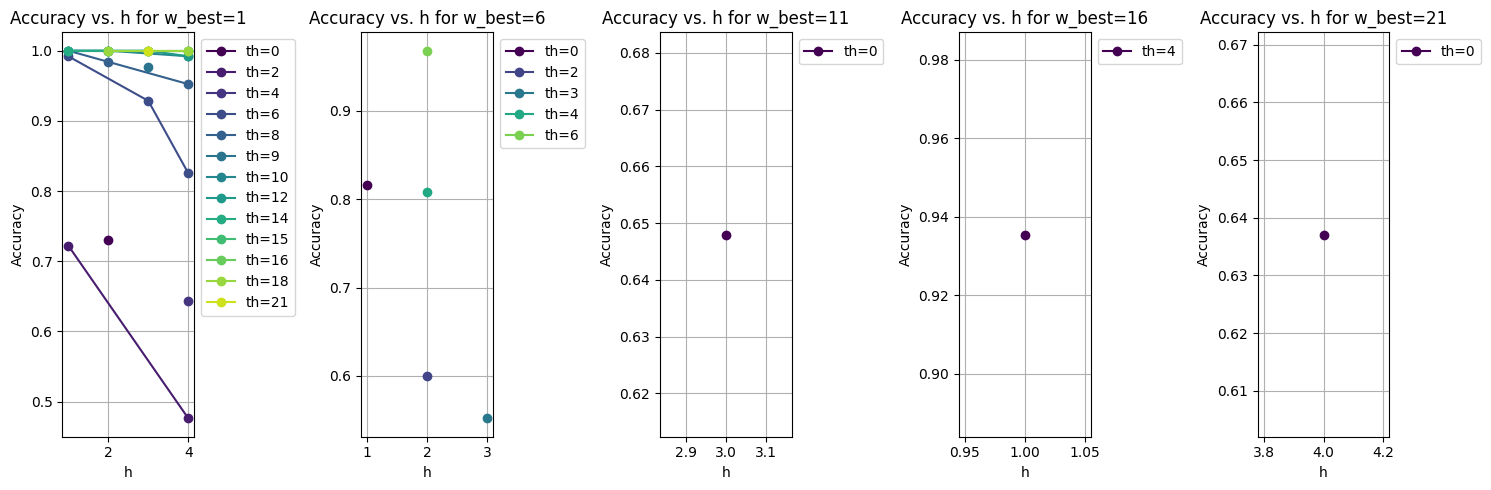

In [693]:
import matplotlib.pyplot as plt

# Your data
data = best_h_th

# Separate the data based on unique w_best values
unique_w_best_values = sorted(set(entry[2] for entry in data))

# Create subplots for each unique w_best
num_subplots = len(unique_w_best_values)
fig, axes = plt.subplots(1, num_subplots, figsize=(15, 5))

# Define a color map for different th values
cmap = plt.get_cmap('viridis')

# Create separate graphs for each unique w_best
for i, w_best_value in enumerate(unique_w_best_values):
    # Filter the data for the current w_best
    filtered_data = [(h, th, w_best, accuracy) for h, th, w_best, accuracy in data if w_best == w_best_value]
    
    # Extract unique th values for the current w_best
    unique_th_values = sorted(set(entry[1] for entry in filtered_data))
    
    # Create a subplot for the current w_best
    ax = axes[i]
    
    # Plot separate lines for each unique th value with different colors
    for j, th_value in enumerate(unique_th_values):
        th_filtered_data = [(h, th, w_best, accuracy) for h, th, w_best, accuracy in filtered_data if th == th_value]
        h_values = [entry[0] for entry in th_filtered_data]
        accuracy_values = [entry[3] for entry in th_filtered_data]
        color = cmap(float(j) / len(unique_th_values))
        ax.plot(h_values, accuracy_values, marker='o', linestyle='-', color=color, label=f'th={th_value}')
    
    # Set titles and labels
    ax.set_title(f'Accuracy vs. h for w_best={w_best_value}')
    ax.set_xlabel('h')
    ax.set_ylabel('Accuracy')
    ax.grid(True)
    
    # Move the legend outside the graph
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


### Conclusions

### Overfitting

In [ ]:
X_val_flat

>1, train MSE: 292.447, validation MSE: 548.026
>2, train MSE: 90.716, validation MSE: 167.742
>3, train MSE: 21.455, validation MSE: 70.067
>4, train MSE: 5.886, validation MSE: 43.218
>5, train MSE: 1.446, validation MSE: 12.785
>6, train MSE: 0.374, validation MSE: 8.981
>7, train MSE: 0.083, validation MSE: 8.445


>8, train MSE: 0.017, validation MSE: 8.113
>9, train MSE: 0.003, validation MSE: 8.210
>10, train MSE: 0.000, validation MSE: 8.109
>11, train MSE: 0.000, validation MSE: 8.121
>12, train MSE: 0.000, validation MSE: 8.233
>13, train MSE: 0.000, validation MSE: 8.172
>14, train MSE: 0.000, validation MSE: 8.108
>15, train MSE: 0.000, validation MSE: 8.120
>16, train MSE: 0.000, validation MSE: 8.255
>17, train MSE: 0.000, validation MSE: 8.171
>18, train MSE: 0.000, validation MSE: 8.393
>19, train MSE: 0.000, validation MSE: 8.270
>20, train MSE: 0.000, validation MSE: 8.178


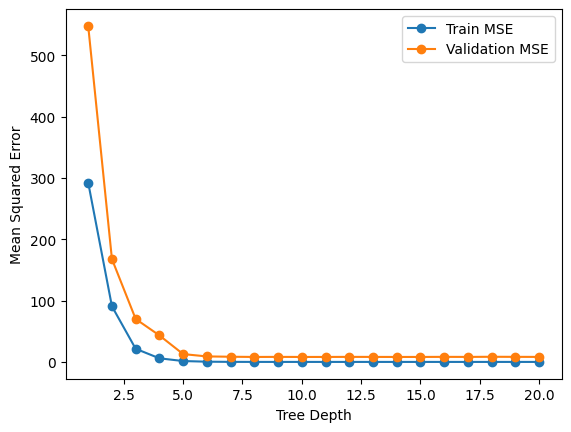

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from matplotlib import pyplot as plt

# create dataset
#X, y = make_classification(n_samples=10000, n_features=20, n_informative=5, n_redundant=15, random_state=1)

# split into train test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# define lists to collect scores
train_scores, val_scores = list(), list()

# define the tree depths to evaluate
values = [i for i in range(1, 21)]

X_Train, X_val, y_Train, y_val = train_test_split(X_train_model, labels, test_size=0.1, random_state=42, shuffle=False)
#X_train_model = X_train_model.values
#X_train_model = X_train_model.reshape(X_train_model.shape[0], -1)
#X_test = X_test.values
#X_Test = X_Test.reshape(X_Test.shape[0], -1)
# evaluate a decision tree for each depth
for i in values:
    # configure the model
    model = DecisionTreeRegressor(max_depth=i)
    
    # fit model on the training dataset
    model.fit(X_Train, y_Train)
    
    # evaluate on the train dataset (regression, so we use mean squared error)
    train_yhat = model.predict(X_Train)
    train_mse = mean_squared_error(y_Train, train_yhat)
    train_scores.append(train_mse)
    
    # evaluate on the test dataset (regression, so we use mean squared error)
    val_yhat = model.predict(X_val)
    val_mse = mean_squared_error(y_val, val_yhat)
    val_scores.append(val_mse)
    
    # summarize progress
    print('>%d, train MSE: %.3f, validation MSE: %.3f' % (i, train_mse, val_mse))

# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train MSE')
plt.plot(values, val_scores, '-o', label='Validation MSE')
plt.xlabel('Tree Depth')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


### Conclusions

### SVM

SVM stands for Support Vector Machines. It is a supervised machine learning algorithm used for both classification and regression tasks.

In the context of classification, an SVM model is trained to find a hyperplane that separates different classes of data points. The goal is to maximize the margin between the hyperplane and the closest data points of each class. These closest data points are known as support vectors, which influence the position and orientation of the hyperplane.

SVMs can handle linearly separable data as well as non-linearly separable data by using a technique called the kernel trick. The kernel trick allows SVMs to implicitly map the input data into a higher-dimensional feature space, where it becomes linearly separable.

In the context of regression, SVMs can also be used to predict continuous values. Instead of finding a hyperplane, the algorithm aims to fit a hyperplane that captures the trend of the data. The hyperplane is then used to make predictions on new data points.

SVMs have several advantages, including their ability to handle high-dimensional data, their robustness against overfitting, and their effectiveness even with a small number of samples.

![https://miro.medium.com/v2/resize:fit:1400/1*qZFPN60NvwbFE_tRg2YPoQ.png](https://miro.medium.com/v2/resize:fit:1400/1*qZFPN60NvwbFE_tRg2YPoQ.png)

In [ ]:
import warnings
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Suppress warnings
warnings.filterwarnings('ignore')

# Define the parameter grid to search over
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'sigmoid', 'poly']}

# Create a TimeSeriesSplit instance
tscv = TimeSeriesSplit(n_splits=5)

# Create an SVR regressor
svr = SVR()

# Create a StandardScaler for feature scaling
scaler = StandardScaler()

# Scale the training data
X_train_scaled = scaler.fit_transform(X_train_model)

# Create a GridSearchCV instance for SVR
grid_search = GridSearchCV(svr, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to your data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", -best_score)  # Negative of MSE is reported

# Note: For prediction, you'll need to transform test data using the same scaler
# and then use grid_search.predict() to get predictions


In [ ]:
## full example: grid search over W , H , th
#W_max  =  8
#W_step =  3 # min W = 1
H_max  =  4
H_step =  1 # min H = 1
#th_max =  5
#th_step = 0.5
y_th_arr = []
X_arr_W    = []
Y_arr_H    = []
Y_arr_H_step    = []
acc_arr = []
y_th_arr_no_penalty = []
Y_arr_H_no_penalty    = []
Y_arr_H_no_penalty_step    = []
acc_arr_no_penalty = []
labels = y_train['open']
X_data = X_train.iloc[:,:-4]
max_acc = 0
values = []
h_acc = {}
h_acc_lst = []

### Optimize over Validation dataset: Creating grid arrays
for h in range(1,H_max,H_step):
  W_max = 3 * H_max
  W_step = W_max // 3
  th_max = int(find_th_max (labels.values, h)) + 1
  th_step = max(th_max // 5, 1)
  values_ = []
  max_acc_ = 0
  for th in range(0,th_max,th_step):
    th_acc = []
    for w in range(1, W_max, W_step):
      print ('h:' , h,'th val:' , th, 'w:', w)
      X, y = sliding_window_th(X_data, labels, w, h, th)

      # Split the data into training and validation sets
      X_Train, X_val, y_Train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

      num_samples, window_size, num_features = X_Train.shape
      X_Train_flat = X_Train.reshape(num_samples, -1)  # Flatten each window sequence

      num_samples, window_size, num_features = X_val.shape
      X_val_flat = X_val.reshape(num_samples, -1)  # Flatten each window sequence
      # Create and train the MLP classifier
      model = SVC(C = 10, kernel = 'linear')

      # Now use X_Train_flat for training
      model.fit(X_Train_flat, y_Train)

      # Make predictions on the validation set
      y_pred = model.predict(X_val_flat)

      # Calculate and store the accuracy score
      accuracy = weighted_accuracy(y_val, y_pred)
      accuracy_no_penalty = accuracy_score(y_val, y_pred)
      #print(accuracy)
      if accuracy > max_acc:
        values.append([h, w, th, accuracy])
        max_acc = accuracy

      if accuracy > max_acc_:
        values_.append(accuracy)
        max_acc_ = accuracy

      # Store the results for each combination of W, H, th
      X_arr_W.append(w)
      Y_arr_H.append(h)
      y_th_arr.append(th)
      acc_arr.append(accuracy)
      if accuracy_no_penalty != 0:
        Y_arr_H_no_penalty.append(h)
        y_th_arr_no_penalty.append(th)
        acc_arr_no_penalty.append(accuracy_no_penalty)
    th_acc.append(values_[-1])

  h_acc[h] = th_acc
  h_acc_lst.append(th_acc)

  h_acc[h] = values_[-1]

th_values = np.arange(0,th_max,th_step)


h: 1 th val: 0 w: 1
h: 1 th val: 0 w: 4
h: 1 th val: 0 w: 7
h: 1 th val: 2 w: 1
h: 1 th val: 2 w: 4
h: 1 th val: 2 w: 7
h: 1 th val: 4 w: 1
h: 1 th val: 4 w: 4
h: 1 th val: 4 w: 7
h: 1 th val: 6 w: 1
h: 1 th val: 6 w: 4
h: 1 th val: 6 w: 7
h: 1 th val: 8 w: 1
h: 1 th val: 8 w: 4
h: 1 th val: 8 w: 7
h: 1 th val: 10 w: 1
h: 1 th val: 10 w: 4
h: 1 th val: 10 w: 7
h: 1 th val: 12 w: 1
h: 1 th val: 12 w: 4
h: 1 th val: 12 w: 7
h: 2 th val: 0 w: 1
h: 2 th val: 0 w: 4
h: 2 th val: 0 w: 7
h: 2 th val: 3 w: 1
h: 2 th val: 3 w: 4
h: 2 th val: 3 w: 7
h: 2 th val: 6 w: 1
h: 2 th val: 6 w: 4
h: 2 th val: 6 w: 7
h: 2 th val: 9 w: 1
h: 2 th val: 9 w: 4
h: 2 th val: 9 w: 7
h: 2 th val: 12 w: 1
h: 2 th val: 12 w: 4
h: 2 th val: 12 w: 7
h: 2 th val: 15 w: 1
h: 2 th val: 15 w: 4
h: 2 th val: 15 w: 7


In [ ]:
values

In [ ]:
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# creating a confusion matrix
cm = confusion_matrix(y_val, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 0, 1])
cm_display.plot()
plt.show()

### Random Forest

The basic idea behind Random Forest is to create an ensemble of decision trees, where each tree is trained on a different subset of the data and features. Random Forest introduces randomness in two ways: random sampling of the data and random feature selection.

During the training process, each tree in the Random Forest is trained on a random subset of the training data, known as bootstrap samples. Additionally, at each split in a tree, a random subset of features is considered for determining the best split.

When it comes to making predictions, each tree in the ensemble independently predicts the target variable, and the final prediction is determined by aggregating the individual predictions. For regression tasks, the predictions from each tree are averaged, while for classification tasks, the final prediction is often determined by majority voting.

Random Forest offers several advantages. It tends to have good predictive performance, can handle large and high-dimensional datasets, and is less prone to overfitting compared to individual decision trees. It can also provide measures of feature importance, allowing for variable selection and interpretation.

Overall, Random Forest is a versatile and powerful algorithm widely used in various domains due to its robustness and accuracy.

![https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/rfc_vs_dt1.png](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/rfc_vs_dt1.png)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid with 'criterion' values as 'squared_error' and 'absolute_error'
param_grid = {
    'n_estimators': [180, 190, 200],
    'criterion': ['squared_error', 'absolute_error'],  # Using 'squared_error' and 'absolute_error'
    'max_depth': [70, 80, 90],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [3, 5]
}

# Create the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=0)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the grid search to your data
grid_search.fit(X_train_model, y_train)  # Replace X_train_model and y_train with your training data

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Optionally, you can also print other information like the best score and results
print("Best Score (Negative Mean Absolute Error):", grid_search.best_score_)


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConvers

Best Parameters: {'criterion': 'squared_error', 'max_depth': 70, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 180}
Best Score (Negative Mean Absolute Error): -3.869657403338065


#### Feature importance

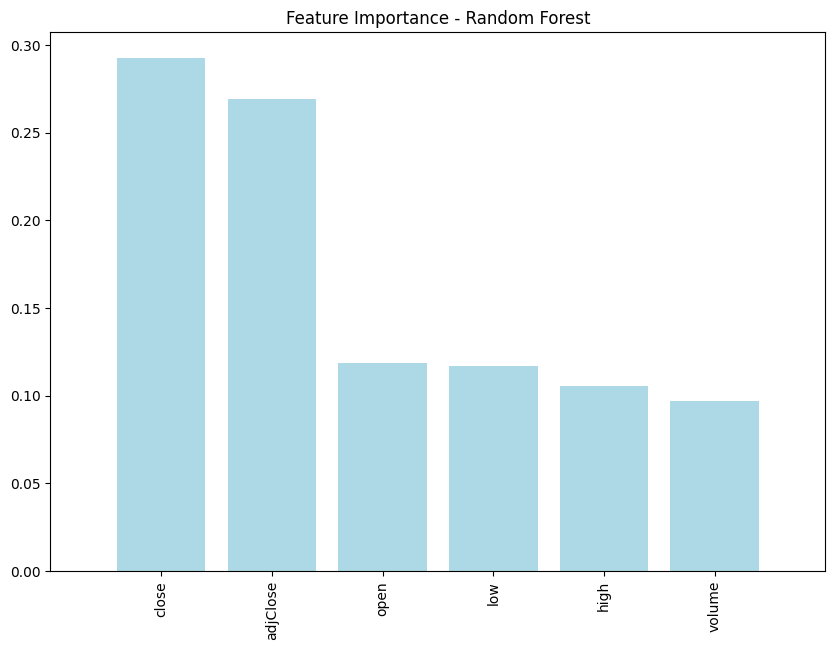

Feature Ranking:
1. close (29.28%)
2. adjClose (26.93%)
3. open (11.88%)
4. low (11.67%)
5. high (10.57%)
6. volume (9.68%)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Assuming X_Train is a 3D array with shape (samples, time_steps, features)
# Reshape it to 2D by combining time_steps and features
X_Train_flat = X_Train.reshape(X_Train.shape[0], -1)

# Create and fit the RandomForestRegressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
R_F_model = rf_regressor.fit(X_Train_flat, y_Train)

# Get feature importances
importances = R_F_model.feature_importances_
desc_indices = np.argsort(importances)[::-1]


names = X_train_model.columns[desc_indices]

# Plot feature importance
plt.figure(figsize=(10, 7))
plt.title("Feature Importance - Random Forest")
plt.bar(range(X_Train_flat.shape[1]), importances[desc_indices], color='lightblue', align='center')
plt.xticks(range(X_Train_flat.shape[1]), names, rotation='vertical')
plt.xlim([-1, X_Train_flat.shape[1]])
plt.show()

# Print the feature ranking
print("Feature Ranking:")
for i, feature in enumerate(names):
    print("{}. {} ({:.2f}%)".format(i + 1, feature, importances[desc_indices][i] * 100))


Feature importance conclusions - Random Forest

We can see that we have two main features that contibute the most to our Random Forest Model. The first one is PageValues and the second one is ExitRates. Our intuition to why these features most important is because PageValues represents the average value for a page that a user visited right before he got to his goal page or made an ecommerce transaction. Our intuition for the second one is that it makes sense that someone has left the website and it depends on the page he was on (a page that he made a purchase or just left the site - tells us a lot about about purchases)

#### Visualization of the Random Forest Classifier Model -

c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


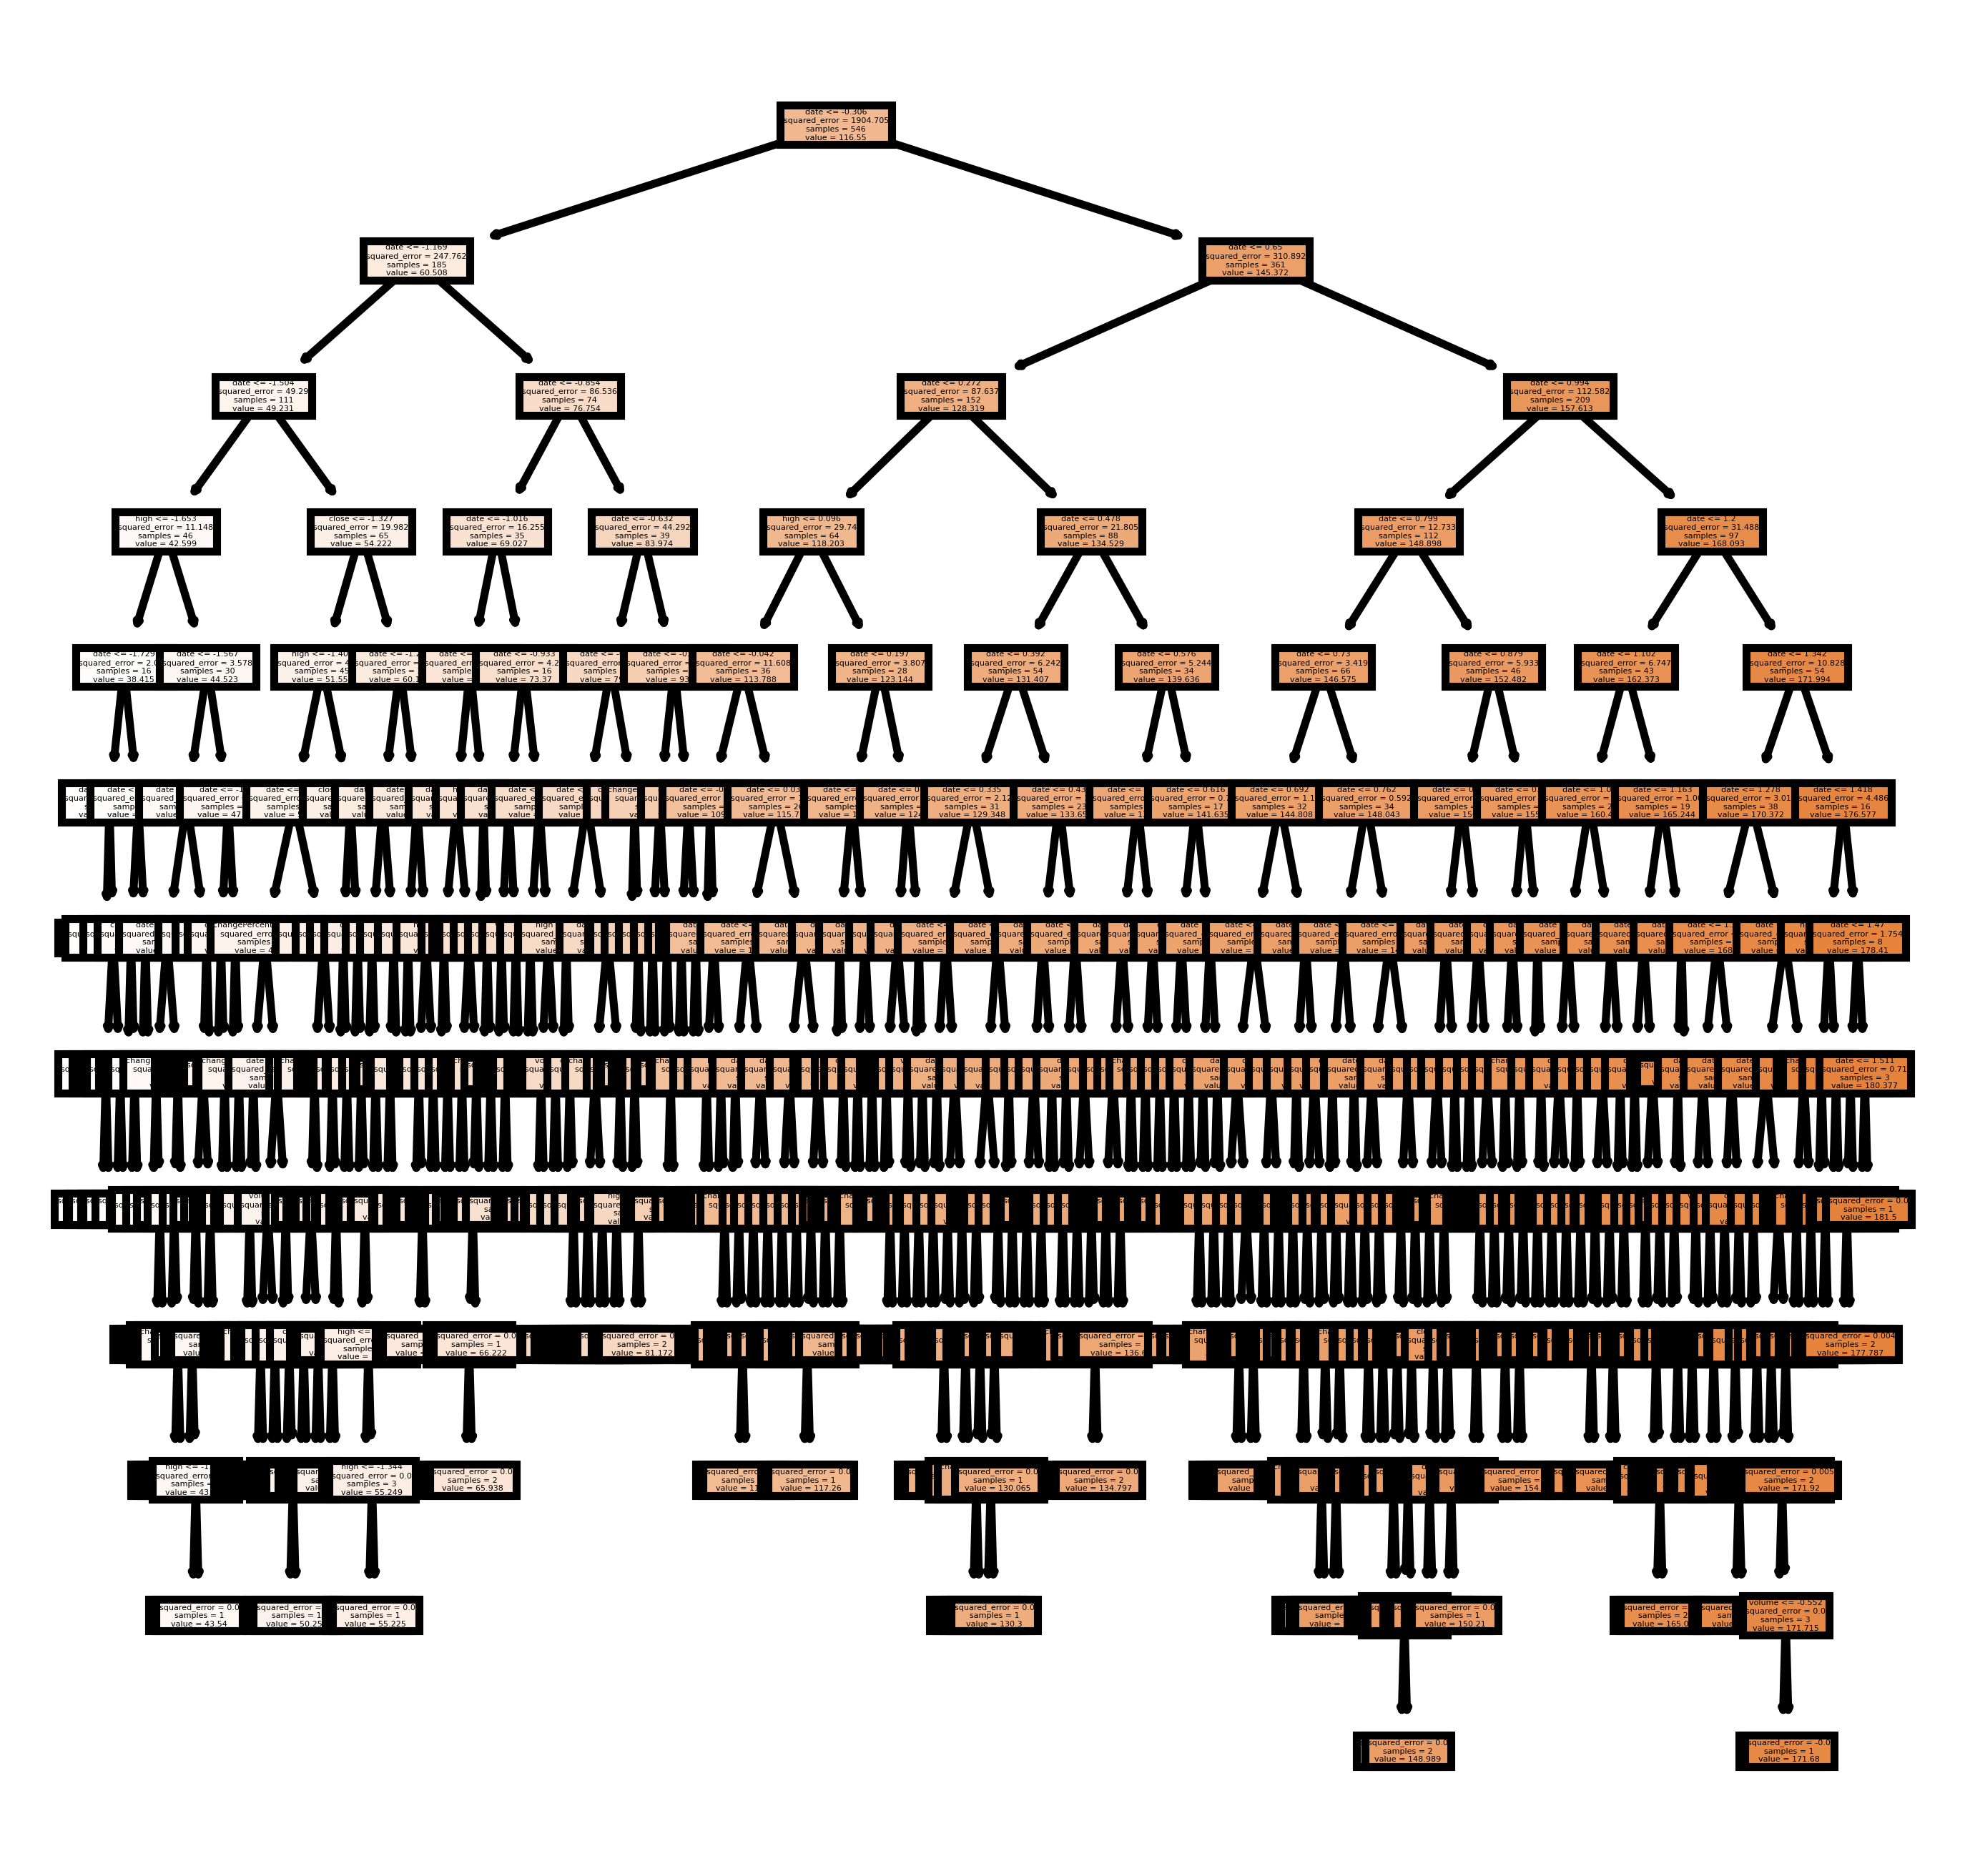

In [ ]:
from sklearn import tree

# Arrange Data into Features Matrix and Target Vector
X = X_train_model
y = y_train

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0)

# Random Forests in `scikit-learn` (with N = 100)
rf = RandomForestRegressor(criterion = 'squared_error', max_depth = 70, min_samples_leaf = 1, min_samples_split = 3, n_estimators = 18).fit(X_train, Y_train)

fn=data_reduction.columns
cn=[]
cn.append('open')
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf.estimators_[0], feature_names = fn.tolist(), class_names=cn, filled = True)
fig.savefig('rf_individualtree.png')

In [ ]:
y_train

open
0     181.5000
1     177.8950
2     178.4400
3     179.9650
4     182.6300
...        ...
1126   41.3450
1127   41.3625
1128   42.2500
1129   42.6225
1130   42.6000

[1131 rows x 1 columns]

In [ ]:
## full example: grid search over W , H , th
#W_max  =  8
#W_step =  3 # min W = 1
H_max  =  3
H_step =  1 # min H = 1
#th_max =  5
#th_step = 0.5
y_th_arr = []
X_arr_W    = []
Y_arr_H    = []
Y_arr_H_step    = []
acc_arr = []
y_th_arr_no_penalty = []
Y_arr_H_no_penalty    = []
Y_arr_H_no_penalty_step    = []
acc_arr_no_penalty = []
labels = y_train['open']
max_acc = 0
values = []
h_acc = {}
h_acc_lst = []

### Optimize over Validation dataset: Creating grid arrays
for h in range(1,H_max,H_step):
  W_max = 3 * H_max
  W_step = W_max // 3
  th_max = int(find_th_max (labels.values, h)) + 1
  th_step = max(th_max // 5, 1)
  values_ = []
  max_acc_ = 0
  for th in range(0,th_max,th_step):
    th_acc = []
    for w in range(1, W_max, W_step):
      print ('h:' , h,'th val:' , th, 'w:', w)
      X, y = sliding_window_th(X_train_model, labels, w, h, th)

      # Split the data into training and validation sets
      X_Train, X_val, y_Train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

      num_samples, window_size, num_features = X_Train.shape
      X_Train_flat = X_Train.reshape(num_samples, -1)  # Flatten each window sequence

      num_samples, window_size, num_features = X_val.shape
      X_val_flat = X_val.reshape(num_samples, -1)  # Flatten each window sequence
      # Create and train the MLP classifier
      model = RandomForestClassifier(criterion = 'gini', max_depth = 70, min_samples_leaf = 1, min_samples_split = 3, n_estimators = 180)

      # Now use X_Train_flat for training
      model.fit(X_Train_flat, y_Train)

      # Make predictions on the validation set
      y_pred = model.predict(X_val_flat)

      # Calculate and store the accuracy score
      accuracy = weighted_accuracy(y_val, y_pred)
      accuracy_no_penalty = accuracy_score(y_val, y_pred)
      #print(accuracy)
      if accuracy > max_acc:
        values.append([h, w, th, accuracy])
        max_acc = accuracy

      if accuracy > max_acc_:
        values_.append(accuracy)
        max_acc_ = accuracy

      # Store the results for each combination of W, H, th
      X_arr_W.append(w)
      Y_arr_H.append(h)
      y_th_arr.append(th)
      acc_arr.append(accuracy)
      if accuracy_no_penalty != 0:
        Y_arr_H_no_penalty.append(h)
        y_th_arr_no_penalty.append(th)
        acc_arr_no_penalty.append(accuracy_no_penalty)
    th_acc.append(values_[-1])

  h_acc[h] = th_acc
  h_acc_lst.append(th_acc)

  h_acc[h] = values_[-1]

th_values = np.arange(0,th_max,th_step)


h: 1 th val: 0 w: 1
h: 1 th val: 0 w: 4
h: 1 th val: 0 w: 7
h: 1 th val: 2 w: 1
h: 1 th val: 2 w: 4
h: 1 th val: 2 w: 7
h: 1 th val: 4 w: 1
h: 1 th val: 4 w: 4
h: 1 th val: 4 w: 7
h: 1 th val: 6 w: 1
h: 1 th val: 6 w: 4
h: 1 th val: 6 w: 7
h: 1 th val: 8 w: 1
h: 1 th val: 8 w: 4
h: 1 th val: 8 w: 7
h: 1 th val: 10 w: 1
h: 1 th val: 10 w: 4
h: 1 th val: 10 w: 7
h: 1 th val: 12 w: 1
h: 1 th val: 12 w: 4
h: 1 th val: 12 w: 7
h: 2 th val: 0 w: 1
h: 2 th val: 0 w: 4
h: 2 th val: 0 w: 7
h: 2 th val: 3 w: 1
h: 2 th val: 3 w: 4
h: 2 th val: 3 w: 7
h: 2 th val: 6 w: 1
h: 2 th val: 6 w: 4
h: 2 th val: 6 w: 7
h: 2 th val: 9 w: 1
h: 2 th val: 9 w: 4
h: 2 th val: 9 w: 7
h: 2 th val: 12 w: 1
h: 2 th val: 12 w: 4
h: 2 th val: 12 w: 7
h: 2 th val: 15 w: 1
h: 2 th val: 15 w: 4
h: 2 th val: 15 w: 7


In [ ]:
values

[[1, 1, 0, 0.504424778761062]]

By the Tree plot we can see that Random forest works on several decision tree. Plotting them gives a hunch basically how a model predicts the value of a target variable by learning simple decision rules inferred from the data features. Every decision at a node is made by classification using single feature from our train data.

### RNN

Recurrent Neural Networks (RNNs) are a type of artificial neural network designed to process sequential data, such as time series or natural language. RNNs have a "recurrent" structure that allows them to maintain and update an internal state as they process each element of the input sequence.

![https://cdn.ttgtmedia.com/rms/onlineimages/enterpriseai-recurrent_neural_network-f_mobile.png](https://cdn.ttgtmedia.com/rms/onlineimages/enterpriseai-recurrent_neural_network-f_mobile.png)

In [ ]:
from scikeras.wrappers import KerasClassifier, KerasRegressor
# https://adriangb.com/scikeras/stable/migration.html

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Assume X_train_W and y_train_W are your pre-processed data.
# X_train_W, y_train_W = ... (Your training data here)

# Convert y_train_W to categorical if it's not already
# y_train_W = to_categorical(y_train_W)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_W, y_train_W, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_W, y_train_W, test_size=0.2, random_state=42)

# Create and compile the RNN model
# model = Sequential()
# model.add(SimpleRNN(64, activation='relu', input_shape=(X_train.shape[1], 1)))
# model.add(Dense(1, activation='softmax'))  # Assume 3 classes for classification
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the model
# history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val))

# # Evaluate the model
# val_loss, val_accuracy = model.evaluate(X_val, y_val)
# print("Validation Loss:", val_loss)
# print("Validation Accuracy:", val_accuracy)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Initialize early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create and compile the RNN model
model = Sequential()
model.add(SimpleRNN(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(3, activation='softmax'))  # Assume 3 classes for classification
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=20,
                    batch_size=4, validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Evaluate the model using one-hot encoded labels
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Print model architecture
model.summary()

# Plot and save model architecture
# plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
# In this example, I added the EarlyStopping callback, monitoring the 'val_loss' (Validation Loss) during training.


In [ ]:
# Plot and save model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Evaluate the model using one-hot encoded labels
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()

# Print model architecture
model.summary()


In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.utils import to_categorical

# Function to generate time series data
def generate_time_series(dim, num_samples, types='random'):
    if types == 'random':
        return np.random.rand(num_samples, dim)

# Function for creating sliding windows
def sliding_window(time_series, W, H, task='classification', threshold=0.1):
    X, y = [], []

    for i in range(len(time_series) - W - H):
        window = time_series[i:i + W]
        next_val_H_steps_ahead = time_series[i + W + H - 1]

        X.append(window)

        if task == 'classification':
            if next_val_H_steps_ahead[0] - window[-1, 0] > threshold:
                y.append(1)
            elif next_val_H_steps_ahead[0] - window[-1, 0] < -threshold:
                y.append(2)
            else:
                y.append(0)

    return np.array(X), np.array(y)

# Function to build Encoder-Decoder model
def build_LSTM_ED(input_dim, W):
    # Encoder
    encoder_inputs = Input(shape=(W, input_dim))
    encoder_lstm, state_h, state_c = LSTM(50, return_state=True)(encoder_inputs)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = RepeatVector(1)(encoder_lstm) # Predicting only 1 time step ahead
    decoder_lstm = LSTM(50, return_sequences=True)(decoder_inputs, initial_state=encoder_states)
    decoder_outputs = TimeDistributed(Dense(3, activation='softmax'))(decoder_lstm)

    model = Model(encoder_inputs, decoder_outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model
def build_GRU_ED(input_dim, W):
    # Encoder
    encoder_inputs = Input(shape=(W, input_dim))
    encoder_gru, state_h = GRU(50, return_state=True)(encoder_inputs)

    # Decoder
    decoder_inputs = RepeatVector(1)(encoder_gru) # Predicting only 1 time step ahead
    decoder_gru = GRU(50, return_sequences=True)(decoder_inputs, initial_state=state_h)
    decoder_outputs = TimeDistributed(Dense(3, activation='softmax'))(decoder_gru)

    model = Model(encoder_inputs, decoder_outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Main code

input_dim = 3
num_samples = 1000
W = 20
H = 5
num_classes = 3

time_series = generate_time_series(input_dim, num_samples)
X, y = sliding_window(time_series, W, H)
y = to_categorical(y, num_classes=num_classes)
y = y[:, np.newaxis, :]

model = build_GRU_ED(input_dim, W)
model.summary()
# Define training hyperparameters
EPOCHS = 10
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# Train the model
history = model.fit(
    X, y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    verbose=1  # For printing the progress during training
)

    # # Train the model with a 10% validation split
    # model.fit([X, decoder_input_data], y, epochs=50, batch_size=64, validation_split = 0.1)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 20, 3)]              0         []                            
                                                                                                  
 gru_9 (GRU)                 [(None, 50),                 8250      ['input_7[0][0]']             
                              (None, 50)]                                                         
                                                                                                  
 repeat_vector_3 (RepeatVec  (None, 1, 50)                0         ['gru_9[0][0]']               
 tor)                                                                                             
                                                                                            

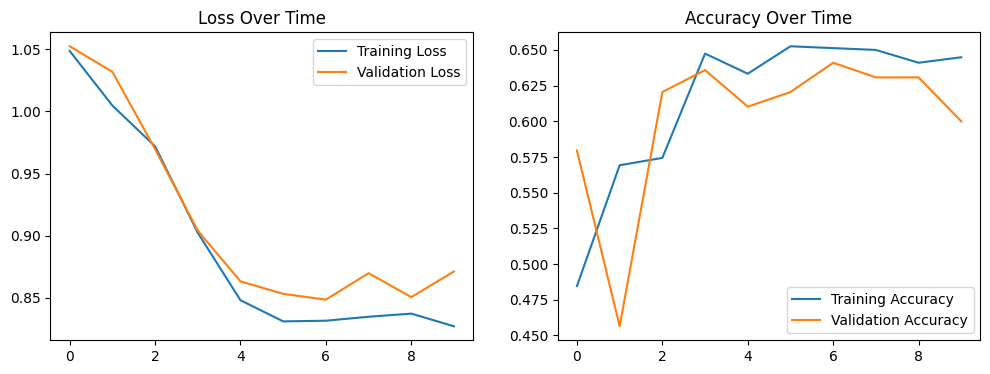

In [ ]:

# Optional: Plotting the training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.legend()

plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, RepeatVector, TimeDistributed, Dense
import numpy as np
from tensorflow.keras.utils import to_categorical

# Define the encoder-decoder model
def build_encoder_decoder(input_shape, output_sequence_length, n_units):
    """
    Build the encoder-decoder GRU model

    Arguments:
    input_shape -- tuple, shape of a single input sequence (e.g. (20, 3) for 20 time steps and 3 features)
    output_sequence_length -- int, number of time steps in the output sequence
    n_units -- int, number of GRU units

    Returns:
    model -- Keras model
    """

    # Encoder
    encoder_inputs = Input(shape=input_shape)
    encoder_gru = GRU(n_units, return_state=True)
    _, encoder_state = encoder_gru(encoder_inputs)

    # Decoder
    decoder_inputs = RepeatVector(output_sequence_length)(encoder_state)
    decoder_gru = GRU(n_units, return_sequences=True)(decoder_inputs, initial_state=encoder_state)
    decoder_outputs = TimeDistributed(Dense(3, activation='softmax'))(decoder_gru)  # Assuming 3 classes for the target

    model = Model(encoder_inputs, decoder_outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to generate time series data
def generate_time_series(dim, num_samples, types='random'):
    if types == 'random':
        return np.random.rand(num_samples, dim)

# Function for creating sliding windows
def sliding_window(time_series, W, H, task='classification', threshold=0.1):
    X = []
    y = []

    for i in range(len(time_series) - W - H):
        window = time_series[i:i + W]
        next_val_H_steps_ahead = time_series[i + W + H - 1]
        X.append(window)

        if task == 'classification':
            if next_val_H_steps_ahead[0] - window[-1, 0] > threshold:
                y.append(1)
            elif next_val_H_steps_ahead[0] - window[-1, 0] < -threshold:
                y.append(2)
            else:
                y.append(0)

    return np.array(X), np.array(y)

# Main code
input_dim = 3       # Number of dimensions
num_samples = 1000  # Length of time series
W = 20              # Window size
H = 5               # Steps ahead for prediction
num_classes = 3     # Number of classes for classification

# Generate 3-dimensional time series data
time_series = generate_time_series(input_dim, num_samples)

# Create training data using sliding windows
X, y = sliding_window(time_series, W, H)
y = to_categorical(y, num_classes=num_classes)
y = y[:, np.newaxis, :]  # Make y 3D to match the output of the model

# Build and train the Encoder-Decoder model
model = build_encoder_decoder((W, input_dim), W, 64)
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 20, 3)]              0         []                            
                                                                                                  
 gru_15 (GRU)                [(None, 64),                 13248     ['input_10[0][0]']            
                              (None, 64)]                                                         
                                                                                                  
 repeat_vector_6 (RepeatVec  (None, 20, 64)               0         ['gru_15[0][1]']              
 tor)                                                                                             
                                                                                            

In [ ]:
# Example for spesific W , H ,
X, Y = X_train.iloc[:,:-4] , y_train.values
W, H , th_model = 5 , 3 , 5 ## choose paraneters/ run it in grid search lo op
X_train_W , y_train_W = sliding_window_th (X , Y , window_size = W , horizon = H, th = th_model)
#####
X_train_W = X_train_W.reshape(X_train_W.shape[0], -1)
np.shape(X_train_W ) , np.shape(y_train_W)

((840, 10), (840,))

In [ ]:
# Create a function to build your RNN model
def build_rnn_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(units, activation=activation, input_shape=(X_train_W.shape[1], 1)))
    model.add(Dense(3, activation='softmax'))  # Assume 3 classes for classification
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define hyperparameters and their possible values
param_grid = {
    'units': [50, 100],  # Number of units in the RNN layer
    'optimizer': ['adam'],  # Optimizer
    'batch_size': [32, 64]  # Batch size
}

# Wrap the Keras model with the KerasClassifier
estimator = KerasClassifier(build_fn=lambda units=50: build_rnn_model(units), verbose=0)

# Create GridSearchCV
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the grid search to your data
grid_search.fit(X_train_W, y_train_W)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict on the validation set using the best model
y_pred = best_model.predict(X_val)

# Calculate accuracy
accuracy = np.mean(y_pred == y_val)

print("Best Parameters:", best_params)
print("Best Validation Accuracy:", accuracy)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


ValueError: Invalid parameter units for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(units=50)`
Check the list of available parameters with `estimator.get_params().keys()`

In [ ]:
from scikeras.wrappers import kerasclassifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load the Iris dataset as an example
iris = load_iris()
X = iris.data
y = iris.target

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a function to build your Keras model
def build_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(8, input_dim=4, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Wrap the Keras model with the KerasClassifier
clf = KerasClassifier(build_fn=build_model, verbose=0)

# Define hyperparameters and their possible values
param_grid = {
    'batch_size': [10, 20, 30],
    'epochs': [10, 20, 30],
}

# Create a GridSearchCV instance to search for the best hyperparameters
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best model with the best hyperparameters
best_model = grid_search.best_estimator_

# Evaluate the best model on the validation set
validation_accuracy = best_model.score(X_val, y_val)

print("Best Parameters:", best_params)
print("Validation Accuracy:", validation_accuracy)


In [ ]:
# Split your data into training and validation sets
X_Train, X_val, y_Train, y_val = train_test_split(X_train_W, y_train_W, test_size=0.2, random_state=42)
X_Train.shape, X_val.shape, X_train_W.shape

### Choosing the best model

As seen in the last section, we got the best accuracy score for ???.Therefor we'll use this model to make our predictions later on.

Confusion Matrix on the ??? Model with the validation data in order to evaluate our model:
צריך להחליף לפי המודל שלנו

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64, return_sequences=True, input_shape=(X_Train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_Train, y_train, epochs=10)


In [ ]:
# Predict using the RNN model
y_pred_prob = model.predict(X_val).flatten()
y_pred = np.round(y_pred_prob).astype(int)

print('Accuracy: {:.2f}'.format(accuracy_score(y_val, y_pred)))


In [ ]:
# Reshape the input data to fit the RNN input requirements
X_Train = np.expand_dims(X_Train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

# Trim the target data to match the number of samples in X_Train
y_train = y_train[:X_Train.shape[0]]
y_val = y_val[:X_val.shape[0]]

# Create the RNN model
rnn_model = Sequential()
rnn_model.add(LSTM(units=50, input_shape=(X_Train.shape[1], X_Train.shape[2])))
rnn_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the RNN model
rnn_model.fit(X_Train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict using the RNN model
y_pred_prob = rnn_model.predict(X_val).flatten()
y_pred = np.round(y_pred_prob).astype(int)

print('Accuracy: {:.2f}'.format(accuracy_score(y_val, y_pred)))


In [ ]:
y_train

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## full example: grid search over W , H , th
#W_max  =  8
#W_step =  3 # min W = 1
H_max  =  4
H_step =  1 # min H = 1
#th_max =  5
#th_step = 0.5
y_th_arr = []
X_arr_W    = []
Y_arr_H    = []
Y_arr_H_step    = []
acc_arr = []
y_th_arr_no_penalty = []
Y_arr_H_no_penalty    = []
Y_arr_H_no_penalty_step    = []
acc_arr_no_penalty = []
labels = y_train['open']
max_acc = 0
values = []
h_acc = {}
h_acc_lst = []

th_dict = {}

### Optimize over Validation dataset: Creating grid arrays
for h in range(1,H_max,H_step):
  W_max = 5 * H_max
  W_step = W_max // 5
  th_max = int(find_th_max (labels.values, h)) + 1
  th_step = th_max // 5
  for th in range(0,th_max,th_step):
    th_acc = []
    th_ac_for_dict = []
    for w in range(1, W_max, W_step):
      print ('h:' , h,'th val:' , th, 'w:', w)
      X, y = sliding_window_th(X_data, labels, w, h, th)

      # Split the data into training and validation sets
      X_Train, X_val, y_Train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

      num_samples, window_size, num_features = X_Train.shape
      # Reshape training data to match the expected input shape
      X_Train_flat = X_Train.reshape(X_Train.shape[0], -1)

# Reshape validation data to match the expected input shape
      X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Create and train the RNN model
      model = Sequential([
        LSTM(100, input_shape=(1, num_features)),  # Input shape modified to match expected shape
        Dense(1, activation='sigmoid')  # Output layer
      ])

      model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Ensure X_Train_flat and y_Train have the same number of samples
      if X_Train.shape[0] != y_Train.shape[0]:
        raise ValueError("X_Train and y_Train must have the same number of samples.")

# Now use the modified X_Train_flat for training
      model.fit(X_Train_flat, y_Train, epochs=10, batch_size=32)

# Make binary predictions on the validation set
      y_pred = model.predict(X_val_flat)
      y_pred_binary = (y_pred >= 0.5).astype(int)  # Convert to binary

# Calculate and store the accuracy score using binary predictions
      accuracy = weighted_accuracy(y_val, y_pred)
      accuracy_no_penalty = accuracy_score(y_val, y_pred_binary)

      if accuracy > max_acc:
        values.append([h, w, th, accuracy])
        max_acc = accuracy

      if accuracy_no_penalty > max_acc_:
        values_.append(accuracy_no_penalty)
        max_acc_ = accuracy_no_penalty

      # Store the results for each combination of W, H, th
      X_arr_W.append(w)
      Y_arr_H.append(h)
      y_th_arr.append(th)
      acc_arr.append(accuracy)
      if accuracy_no_penalty != 0:
        Y_arr_H_no_penalty.append(h)
        y_th_arr_no_penalty.append(th)
        acc_arr_no_penalty.append(accuracy_no_penalty)
      th_ac_for_dict.append(accuracy_no_penalty)
    th_acc.append(values_[-1])
    th_dict[th] = th_ac_for_dict

  h_acc[h] = th_acc
  h_acc_lst.append(th_acc)

  h_acc[h] = values_[-1]

th_values = np.arange(0,th_max,th_step)

In [ ]:
y_Train.shape

In [ ]:
X_Train_flat.sh

explenation for validation confusion matrix:
???

#### Differences between train and validation

In this section we'd like to find out if our best ML model by accuracy score suffers from overfitting.
Overfitting is a common problem in machine learning where a model learns the training data too well, resulting in poor performance on unseen data. It occurs when a model becomes overly complex and captures noise or random fluctuations in the training data as genuine patterns. This leads to the model fitting the training data perfectly but failing to generalize to new examples.
To check if this is the case, we'll plot a ROC curve for our train data. If the AUC that we get will be very close to 1, we can assume our model suffers from overfitting, otherwise we're all good.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

metrics.plot_roc_curve(clf_lr, X_Train, y_Train)
plt.show()

Conclusions from the differences between the Train and Validation (Overfitting):<br>
Based on the chosen model, we have got Train And test AUC of ???. Therefore, this model is ??? overfitted.
להוסיף הסבר כשיהיו תוצאות

## Making a prediction

In this part we'll make our predictions on the test dataset we've created using the module who preformed the best out of all modules we ran in earlier stages of the project - ???.

After the testing, we will discuss our results (and how good they are) and insights we got from our project with regards to the dataset in hand.

In [ ]:
pd.DataFrame(X_test)

0        1        2        3          4          5         6    
0     42.915  42.9475    41.75  42.1575  40.571255  189126660  47281665  \
1      41.25  42.5225  40.8325     42.4  40.804626  248103976  62025994   
2    43.3725  43.6225   42.075  42.1225  40.537567  169126524  42281631   
3      42.94   43.695   42.605    43.68  42.036465  172352840  43088210   
4    45.2375  45.5975  44.0675  44.1725  42.510426  165377128  41344282   
..       ...      ...      ...      ...        ...        ...       ...   
121   46.285  46.5825  45.8625  46.4225  44.364838  134313820  33578455   
122    46.97   47.305     46.8   47.185   45.09354   73939460  18484865   
123  47.5075    47.54   47.065    47.21  45.117424  246876640  61719160   
124  47.8875  47.8925   47.555     47.7  45.585709   86440296  21610074   
125   48.105    48.22    47.61   47.675  45.561825   86553572  21638393   

         7        8      9         10  
0   -0.7575    -1.77  42.24   -0.0177  
1      1.15     2.79  41.74    0.0279  
2     -1.25    -2.88   42.6   -0.0288  
3      0.74     1.72  43.13    0.0172  
4    -1.065    -2.35  44.68   -0.0235  
..      ...      ...    ...       ...  
121  0.1375  0.29707  46.32  0.002971  
122   0.215  0.45774  47.16  0.004577  
123 -0.2975 -0.62622  47.27 -0.006262  
124 -0.1875 -0.39154  47.73 -0.003915  
125   -0.43 -0.89388  47.89 -0.008939  

[126 rows x 11 columns]

In [ ]:
X_test_model = X_Test.iloc[:,:-4]

In [ ]:
X_test_model

open      high       low     close  adjClose    volume
0   -1.877925 -1.877925 -2.030694 -1.988003  0.976994 -1.285888
1   -2.265646 -2.265646 -2.245167 -1.931944  1.982425  2.093586
2   -1.771389 -1.771389 -1.954722 -1.996095  0.636036 -2.108523
3   -1.872103 -1.872103 -1.830830 -1.636036  0.691038  1.300596
4   -1.337094 -1.337094 -1.488958 -1.522183  0.572117 -1.715734
..        ...       ...       ...       ...       ...       ...
121 -1.093167 -1.093167 -1.069362 -1.076724  0.042557  0.246044
122 -0.933654 -0.933654 -0.850214 -0.901678 -0.986691  0.365119
123 -0.808489 -0.808489 -0.788268 -0.895941  1.961502 -0.438218
124 -0.720000 -0.720000 -0.673726 -0.783451 -0.773579 -0.264294
125 -0.669352 -0.669352 -0.660869 -0.789189 -0.771648 -0.636584

[126 rows x 6 columns]

In [ ]:
# Load the trained MLP model
loaded_model = joblib.load('mlp_model.pkl')

# Set the optimal parameters
h_optimal = 13
w_optimal = 5
th_optimal = 0

# Preprocess the test data (assuming you need sliding window transformation)
X_test, _ = sliding_window_th(X_test_model, labels, w_optimal, h_optimal, th_optimal)

# Load the trained MLP model
loaded_model = joblib.load('mlp_model.pkl')

# Ensure that the shape of X_test_transformed matches the training data preprocessing
# For example, if you flattened the training data to (number_of_samples, -1), do the same for X_test
num_samples, _, _ = X_test.shape
X_test_flat = X_test.reshape(num_samples, -1)

# Make predictions on the test data
y_pred = loaded_model.predict(X_test_flat)

# Now, y_pred contains the predicted labels for the test data
# You can use y_pred for further analysis or evaluation



## Recap & Conclusions